In [888]:
'''
File name: Gender_gap_evolution.ipynb
Authors: Yasmin El Euch, Aliénor Bénédicte G Hamoir, Clara Rossignol, Guillaume David E. Ryelandt
Date created: 29/11/2022
Date last modified: 23/12/2022
Python version: 3.8.8
'''

'\nFile name: Gender_gap_evolution.ipynb\nAuthors: Yasmin El Euch, Aliénor Bénédicte G Hamoir, Clara Rossignol, Guillaume David E. Ryelandt\nDate created: 29/11/2022\nDate last modified: 23/12/2022\nPython version: 3.8.8\n'

# The evolution of the gender gap in the film industry

Our goal with this work is to analyze the evolution in time of sexism and women discrimination in the film industry, which is known as one of the least women-friendly industries: [almost 9 in 10 films (89%) have more men in their 10 or so most senior roles, both acting and non-acting](https://www.bbc.com/culture/article/20180508-the-data-that-reveals-the-film-industrys-woman-problem). The #MeToo movement, known for its apogee in 2017 with the complaints of many known actresses about the sexism and assaults in the film industry, appeared in reality in 2007. It made less noise back then, but it was present and in many fields. The premises of free speech and liberation about the harassment, assault and rape culture women were suffering of, were launched. We want to tell the story of those women, particularly in the film industry, who suffer from daily discrimination. We want to have a look at the gender gap and how it has evolved in time, especially after the appearance of the #MeToo movement? Finally, the goal is to assess whether this movement has had a real impact on the situation.

## Table of contents

0. [General Information](#GI)\
        A. [Folder structure](#Folder)\
        B. [Data](#Data)\
        C. [Imports](#Imports)\
        D. [Paths](#Paths)

1. [Data scraping, pre-processing and dataset construction](#Step-1)\
        A. [Pre-processing](#Pre-pro)\
        B. [Other datatsets pre-processing](#Other_ds)\
        C. [First insights on gender gap](#First_insights)

2. [Box office revenues, salaries](#Box_Office)
3. [Evolution of women representation ](#Evolution)\
        A. [Are women present?] (#Presence)\
        B. [What are women associated with? How do we talk about these women?] (#Association)\
        C. [What kind of roles and jobs women do are the most appreciated? In which context do people like to see women?] (#Roles)\
        D. [How do women interact, with other women and with men?] (#Interaction)
4. [Conclusion](#Conclusion)


---
# 0. General Information <a id="GI"> </a> 

## A. Folder structure <a id="Folder"> </a>

## B. Data <a id="Data"> </a>

***Files and directories to make this notebook run successfully:***

- **data/**
    - *character.metadata.tsv*
    - *movie.metadata.tsv*
    - *name.clusters.txt*
    - *plot_summaries.txt*
    - *tvtropes.clusters.txt*
    - *oscar_winners.csv*
    - *movie_appreciation_metadata.csv*
    - *title.ratings.tsv*
    - *title.basics.tsv*
    


- *preprocessing.ipynb*

Directories are in **bold** and files are in *italic*.

`movie.metadata.tsv.gz` [3.4 M]

Metadata for 81,741 movies, extracted from the November 4, 2012 dump of Freebase. Tab-separated. The columns are:

1. Wikipedia movie ID
2. Freebase movie ID
3. Movie name
4. Movie release date
5. Movie box office revenue
6. Movie runtime
7. Movie languages (Freebase ID:name tuples)
8. Movie countries (Freebase ID:name tuples)
9. Movie genres (Freebase ID:name tuples)


`name.clusters.txt`

970 unique character names used in at least two different movies, along with 2,666 instances of those types.  The ID field indexes into the Freebase character/actor map ID in character.metadata.tsv.


`plot_summaries.txt` [29 M] 

Plot summaries of 42,306 movies extracted from the November 2, 2012 dump of English-language Wikipedia.  Each line contains the Wikipedia movie ID (which indexes into movie.metadata.tsv) followed by the summary.


`tvtropes.clusters.txt`

72 character types drawn from tvtropes.com, along with 501 instances of those types.  The ID field indexes into the Freebase character/actor map ID in character.metadata.tsv.


`corenlp_plot_summaries.tar` [628 M, separate download]

The plot summaries from above, run through the Stanford CoreNLP pipeline (tagging, parsing, NER and coref). Each filename begins with the Wikipedia movie ID (which indexes into movie.metadata.tsv).

`oscar.winners.csv` [794 K]

Oscar winners in every field for the last years.


`title.basics.txt` [807.6 M]

Title of movies linked to their alphanumeric unique identifier, from IMDb interface.


`title.ratings.txt` [21.7 M]

Ratings and number of votes for movies, from IMDb interface.


## C. Imports <a id="Imports"> </a>

***Libraries used for milestone 2:***
- python=3.8.12
- pandas
- ast
- datetime
- seaborn
- numpy
- matplotlib
- json

In [889]:
#Imports used in this notebook
from datetime import datetime

import ast
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json as js 
import datetime as dt

## D. Paths <a id="Paths"> </a>

Required to adapt those path to local file organization

In [890]:
### PATHs for dataset:
PATH_DATA = 'data/'

PATH_MOVIE_METADATA = PATH_DATA+'movie.metadata.tsv'
PATH_PLOT_SUMMARY = PATH_DATA+'plot_summaries.txt'
PATH_CHARACTER_METADATA = PATH_DATA+'character.metadata.tsv'
PATH_NAME_CLUSTERS=PATH_DATA+'name.clusters.txt'
PATH_TV_TROPES_CLUSTERS=PATH_DATA+'tvtropes.clusters.txt'

#additionnal datasets:
PATH_MOVIE_OSCAR_WINNERS = PATH_DATA+'oscar_winners.csv'
PATH_MOVIE_APPRECIATION = PATH_DATA+'movie_appreciation_metadata.csv'
PATH_TITLE_BASICS = PATH_DATA+'title.basics.tsv'
PATH_TITLE_RATINGS = PATH_DATA+'title.ratings.tsv'


---
#  1. Data scraping, pre-processing and dataset construction<a id="Step-1"> </a>

## A. Pre-processing <a id="#Pre-pro"> </a>

In [891]:
def dict_to_cols(row): 
    '''
    Allows to transform the dictionnary into a dataframe with multiple columns.
    :param row : row to transform
    :return : 
    '''
    d = js.loads(row[1])
    return row[0], *list(d.values())

def dict_to_lst(stri):
    '''
    Allows to transform a dictionnary into a list of features.
    :param stri : 
    :return : list of features
    '''
    dict = ast.literal_eval(stri)
    lst  = list(dict.values())
    return lst

First we will properly name each column of  in order to manipulate in an easier way

In [892]:
print("Reading in movie data")


movie_headers = ['Wikipedia_movie_ID', 'Freebase_movie_ID', 'Movie_name','Movie_release_date','Movie_box_office_revenue',
                 'Movie_runtime','Movie_languages','Movie_countries','Movie_genres']
plot_headers = ['Wikipedia_movie_ID','Plot_Summary']
character_headers = ['Wikipedia_movie_ID', 'Freebase_movie_ID','Movie_release_date','Character_name','Actor_date_of_birth',
                     'Actor_gender','Actor_height','Actor_ethnicity','Actor_name','Actor_age_at_movie_release',
                     'Freebase_character_actor_map_ID','Freebase_character_ID','Freebase_actor_ID']
name_clusters_headers=['Character_name', 'Freebase_movie_ID']
tv_tropes_cluster_headers=['Trope','Character_name','movie','id','actor']
new_cols_apprec=['movie_title','director name','duration','country','actor_1_name','actor_2_name','actor_3_name',
                    'movie_facebook_likes','actor_1_facebook_likes','actor_2_facebook_likes','actor_3_facebook_likes',
                    'director_facebook_likes','gross','genres','num_voted_users','cast_total_facebook_likes',
                    'facenumber_in_poster','num_user_for_reviews','content_rating','budget',
                    'title_year','imdb_score','aspect_ratio'
                    ]

# Read in movie metadata, plot summaries, and character metadata.
movie_metadata = pd.read_csv(PATH_MOVIE_METADATA,sep='\t',header=None,names=movie_headers,index_col=0)
plot_summaries = pd.read_csv(PATH_PLOT_SUMMARY,sep='\t',index_col=0,names=plot_headers)
character_metadata = pd.read_csv(PATH_CHARACTER_METADATA,sep='\t',header=None,names=character_headers,index_col='Wikipedia_movie_ID')
name_clusters=pd.read_csv(PATH_NAME_CLUSTERS,sep='\t',header=None,names=name_clusters_headers,index_col='Freebase_movie_ID')
tv_tropes_clusters = pd.read_csv(PATH_TV_TROPES_CLUSTERS,sep='\t',header=None).apply(dict_to_cols, axis=1, result_type='expand')

# Read in additionnal datasets
movie_appreciation_metadata = pd.read_csv(PATH_MOVIE_APPRECIATION,header=0)
movie_oscar_winners=pd.read_csv(PATH_MOVIE_OSCAR_WINNERS,header=0)
IMDb_basics=pd.read_csv(PATH_TITLE_BASICS,sep='\t',header=0,index_col=0, dtype={'isAdult': str}) #define dtype of isAdult to avoid warning on reading
IMDb_ratings=pd.read_csv(PATH_TITLE_RATINGS,sep='\t',header=0, index_col=0)

# Cleaning datasets
tv_tropes_clusters.columns = tv_tropes_cluster_headers
tv_tropes_clusters.set_index('id')
movie_metadata['Movie_languages']=movie_metadata['Movie_languages'].apply(lambda x: dict_to_lst(x))
movie_metadata['Movie_countries']=movie_metadata['Movie_countries'].apply(lambda x: dict_to_lst(x))
movie_metadata['Movie_genres']=movie_metadata['Movie_genres'].apply(lambda x: dict_to_lst(x))

# Cleaning for the additionnal dataset
movie_appreciation_metadata=movie_appreciation_metadata.drop(['color','movie_imdb_link'], axis=1)
movie_appreciation_metadata=movie_appreciation_metadata.reindex(columns=new_cols_apprec)
movie_oscar_winners=movie_oscar_winners.replace('1927/1928','1928').replace('1928/1929','1929').replace(
    '1929/1930','1930').replace('1930/1931','1931').replace('1931/1932','1932').replace('1932/1933','1933')
IMDb_basics = IMDb_basics.drop(['isAdult','endYear','runtimeMinutes'], axis=1)

# Displaying the datasets
display(movie_metadata.head())
display(plot_summaries.head())
display(character_metadata.head())
display(name_clusters.head())
display(tv_tropes_clusters.head())
display(movie_appreciation_metadata.head())
display(movie_oscar_winners.head())
display(IMDb_basics.head())
display(IMDb_ratings.head())

Reading in movie data


Freebase_movie_ID  \
Wikipedia_movie_ID                     
975900                     /m/03vyhn   
3196793                    /m/08yl5d   
28463795                  /m/0crgdbh   
9363483                   /m/0285_cd   
261236                     /m/01mrr1   

                                                           Movie_name  \
Wikipedia_movie_ID                                                      
975900                                                 Ghosts of Mars   
3196793             Getting Away with Murder: The JonBenét Ramsey ...   
28463795                                                  Brun bitter   
9363483                                              White Of The Eye   
261236                                              A Woman in Flames   

                   Movie_release_date  Movie_box_office_revenue  \
Wikipedia_movie_ID                                                
975900                     2001-08-24                14010832.0   
3196793                    2000-02-16                       NaN   
28463795                         1988                       NaN   
9363483                          1987                       NaN   
261236                           1983                       NaN   

                    Movie_runtime       Movie_languages  \
Wikipedia_movie_ID                                        
975900                       98.0    [English Language]   
3196793                      95.0    [English Language]   
28463795                     83.0  [Norwegian Language]   
9363483                     110.0    [English Language]   
261236                      106.0     [German Language]   

                               Movie_countries  \
Wikipedia_movie_ID                               
975900              [United States of America]   
3196793             [United States of America]   
28463795                              [Norway]   
9363483                       [United Kingdom]   
261236                               [Germany]   

                                                         Movie_genres  
Wikipedia_movie_ID                                                     
975900              [Thriller, Science Fiction, Horror, Adventure,...  
3196793              [Mystery, Biographical film, Drama, Crime Drama]  
28463795                                       [Crime Fiction, Drama]  
9363483             [Thriller, Erotic thriller, Psychological thri...  
261236                                                        [Drama]

Plot_Summary
Wikipedia_movie_ID                                                   
23890098            Shlykov, a hard-working taxi driver and Lyosha...
31186339            The nation of Panem consists of a wealthy Capi...
20663735            Poovalli Induchoodan  is sentenced for six yea...
2231378             The Lemon Drop Kid , a New York City swindler,...
595909              Seventh-day Adventist Church pastor Michael Ch...

Freebase_movie_ID Movie_release_date  \
Wikipedia_movie_ID                                        
975900                     /m/03vyhn         2001-08-24   
975900                     /m/03vyhn         2001-08-24   
975900                     /m/03vyhn         2001-08-24   
975900                     /m/03vyhn         2001-08-24   
975900                     /m/03vyhn         2001-08-24   

                                Character_name Actor_date_of_birth  \
Wikipedia_movie_ID                                                   
975900                                Akooshay          1958-08-26   
975900              Lieutenant Melanie Ballard          1974-08-15   
975900                     Desolation Williams          1969-06-15   
975900                      Sgt Jericho Butler          1967-09-12   
975900                         Bashira Kincaid          1977-09-25   

                   Actor_gender  Actor_height Actor_ethnicity  \
Wikipedia_movie_ID                                              
975900                        F         1.620             NaN   
975900                        F         1.780      /m/044038p   
975900                        M         1.727         /m/0x67   
975900                        M         1.750             NaN   
975900                        F         1.650             NaN   

                            Actor_name  Actor_age_at_movie_release  \
Wikipedia_movie_ID                                                   
975900                  Wanda De Jesus                        42.0   
975900              Natasha Henstridge                        27.0   
975900                        Ice Cube                        32.0   
975900                   Jason Statham                        33.0   
975900                     Clea DuVall                        23.0   

                   Freebase_character_actor_map_ID Freebase_character_ID  \
Wikipedia_movie_ID                                                         
975900                                  /m/0bgchxw            /m/0bgcj3x   
975900                                   /m/0jys3m            /m/0bgchn4   
975900                                   /m/0jys3g            /m/0bgchn_   
975900                                  /m/02vchl6            /m/0bgchnq   
975900                                  /m/02vbb3r            /m/0bgchp9   

                   Freebase_actor_ID  
Wikipedia_movie_ID                    
975900                    /m/03wcfv7  
975900                     /m/0346l4  
975900                    /m/01vw26l  
975900                     /m/034hyc  
975900                     /m/01y9xg

Character_name
Freebase_movie_ID               
/m/0k3w9c          Stuart Little
/m/0k3wcx          Stuart Little
/m/0k3wbn          Stuart Little
/m/0jyg35               John Doe
/m/0k2_zn               John Doe

Trope             Character_name        movie  \
0  absent_minded_professor  Professor Philip Brainard      Flubber   
1  absent_minded_professor         Professor Keenbean  Richie Rich   
2  absent_minded_professor         Dr. Reinhardt Lane   The Shadow   
3  absent_minded_professor         Dr. Harold Medford        Them!   
4  absent_minded_professor             Daniel Jackson     Stargate   

           id            actor  
0   /m/0jy9q0   Robin Williams  
1  /m/02vchl3  Michael McShane  
2   /m/0k6fkc     Ian McKellen  
3   /m/0k6_br     Edmund Gwenn  
4   /m/0k3rhh     James Spader

movie_title  director name  duration  \
0                                            Avatar             NaN     178.0   
1          Pirates of the Caribbean: At World's End             NaN     169.0   
2                                           Spectre             NaN     148.0   
3                             The Dark Knight Rises             NaN     164.0   
4  Star Wars: Episode VII - The Force Awakens    ...            NaN       NaN   

  country     actor_1_name      actor_2_name          actor_3_name  \
0     USA      CCH Pounder  Joel David Moore             Wes Studi   
1     USA      Johnny Depp     Orlando Bloom        Jack Davenport   
2      UK  Christoph Waltz      Rory Kinnear      Stephanie Sigman   
3     USA        Tom Hardy    Christian Bale  Joseph Gordon-Levitt   
4     NaN      Doug Walker        Rob Walker                   NaN   

   movie_facebook_likes  actor_1_facebook_likes  actor_2_facebook_likes  ...  \
0                 33000                  1000.0                   936.0  ...   
1                     0                 40000.0                  5000.0  ...   
2                 85000                 11000.0                   393.0  ...   
3                164000                 27000.0                 23000.0  ...   
4                     0                   131.0                    12.0  ...   

                            genres  num_voted_users  \
0  Action|Adventure|Fantasy|Sci-Fi           886204   
1         Action|Adventure|Fantasy           471220   
2        Action|Adventure|Thriller           275868   
3                  Action|Thriller          1144337   
4                      Documentary                8   

   cast_total_facebook_likes facenumber_in_poster  num_user_for_reviews  \
0                       4834                  0.0                3054.0   
1                      48350                  0.0                1238.0   
2                      11700                  1.0                 994.0   
3                     106759                  0.0                2701.0   
4                        143                  0.0                   NaN   

   content_rating       budget  title_year imdb_score  aspect_ratio  
0           PG-13  237000000.0      2009.0        7.9          1.78  
1           PG-13  300000000.0      2007.0        7.1          2.35  
2           PG-13  245000000.0      2015.0        6.8          2.35  
3           PG-13  250000000.0      2012.0        8.5          2.35  
4             NaN          NaN         NaN        7.1           NaN  

[5 rows x 23 columns]

Year  Ceremony    Award  Winner                 Name              Film
0  1928         1    Actor     NaN  Richard Barthelmess         The Noose
1  1928         1    Actor     1.0        Emil Jannings  The Last Command
2  1928         1  Actress     NaN       Louise Dresser   A Ship Comes In
3  1928         1  Actress     1.0         Janet Gaynor        7th Heaven
4  1928         1  Actress     NaN       Gloria Swanson    Sadie Thompson

titleType            primaryTitle           originalTitle startYear  \
tconst                                                                          
tt0000001     short              Carmencita              Carmencita      1894   
tt0000002     short  Le clown et ses chiens  Le clown et ses chiens      1892   
tt0000003     short          Pauvre Pierrot          Pauvre Pierrot      1892   
tt0000004     short             Un bon bock             Un bon bock      1892   
tt0000005     short        Blacksmith Scene        Blacksmith Scene      1893   

                             genres  
tconst                               
tt0000001         Documentary,Short  
tt0000002           Animation,Short  
tt0000003  Animation,Comedy,Romance  
tt0000004           Animation,Short  
tt0000005              Comedy,Short

averageRating  numVotes
tconst                            
tt0000001            5.7      1924
tt0000002            5.8       261
tt0000003            6.5      1740
tt0000004            5.6       176
tt0000005            6.2      2554

We have extracted the data and can see that there is some preprocessing to be done.

`movie.metadata.tsv`

Firstly, the movie release dates are not standardized: some are in a year-month-day format and some only have the release year. Secondly, for some of the columns (Movie languages, Movie countries, and Movie genres) the way we the data is presented might not be the best (dictionary with ID and actual "value).
We also need to look for any column containing NaN values and see what we want to do with these missing values. Depending on what data we need for each of our research axis, we might deal differently with NaNs.

We can see that some values are missing, movie languages, movie countries and movie genres are lists. Also the dates don't all have the same format, in fact, some are missing the month and day. 

In [893]:
name_clusters.head()

Character_name
Freebase_movie_ID               
/m/0k3w9c          Stuart Little
/m/0k3wcx          Stuart Little
/m/0k3wbn          Stuart Little
/m/0jyg35               John Doe
/m/0k2_zn               John Doe

This data set shows the characters appearing in different movies. This might be unuselful for our analysis since we analyze movies one by one.

First of all, we make an inspection of the dataframes, to see wether there exist some duplicates, NaN values etc... 

In [894]:
movie_metadata.index.is_unique

True

In [895]:
movie_metadata.isna().any()

Freebase_movie_ID           False
Movie_name                  False
Movie_release_date           True
Movie_box_office_revenue     True
Movie_runtime                True
Movie_languages             False
Movie_countries             False
Movie_genres                False
dtype: bool

Here is a more visual way to see which columns of the dataset contain missing entries. Such that, every white line is a missing value of the dataset.

Sum of NaN in each feature : 


Freebase_movie_ID               0
Movie_name                      0
Movie_release_date           6902
Movie_box_office_revenue    73340
Movie_runtime               20450
Movie_languages                 0
Movie_countries                 0
Movie_genres                    0
dtype: int64

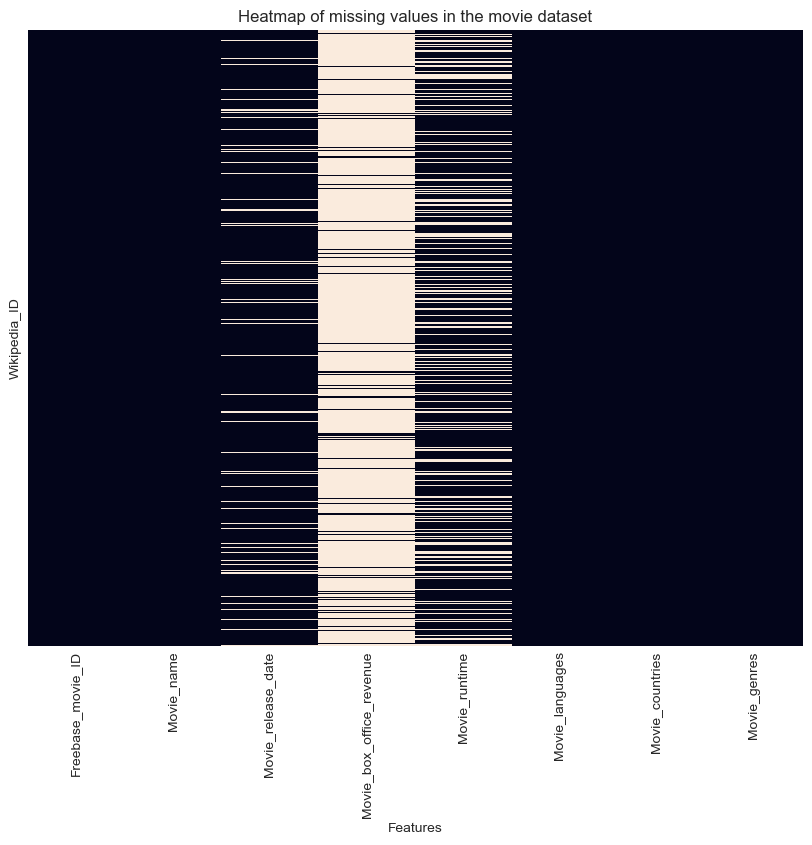

In [896]:
fig, ax = plt.subplots(figsize=(10,8)) 
sns.heatmap(movie_metadata.isna(), yticklabels=False, cbar=False)
ax.set(xlabel="Features", ylabel="Wikipedia_ID")
ax.set_title('Heatmap of missing values in the movie dataset')

print('Sum of NaN in each feature : ')
movie_metadata.isna().sum(axis = 0)

In [897]:
n_movie=len(movie_metadata)
print('Percentage of missing entries in the movie.metadata dataset:\n', 100*movie_metadata[['Movie_release_date', 'Movie_box_office_revenue', 'Movie_runtime']].isna().sum() / n_movie)

Percentage of missing entries in the movie.metadata dataset:
 Movie_release_date           8.443743
Movie_box_office_revenue    89.722416
Movie_runtime               25.018045
dtype: float64


We are missing a lot of the data on the movie box office revenue. Maybe we should try and find those missing informations in another dataset as this could be helpful in our analysis. For the release dates and runtime we could discard the rows with missing values but it could be interesting to check if the rows discarded contain on average more or less lead women characters  or women directors so that we don't overlook any data.

`plot_summaries.txt`

In [898]:
print("Reading in summaries data")
plot_summaries.head()

Reading in summaries data


Plot_Summary
Wikipedia_movie_ID                                                   
23890098            Shlykov, a hard-working taxi driver and Lyosha...
31186339            The nation of Panem consists of a wealthy Capi...
20663735            Poovalli Induchoodan  is sentenced for six yea...
2231378             The Lemon Drop Kid , a New York City swindler,...
595909              Seventh-day Adventist Church pastor Michael Ch...

In [899]:
plot_summaries.index.is_unique

True

In [900]:
print('Sum of NaN in each feature : ')
plot_summaries.isna().sum(axis = 0)

Sum of NaN in each feature : 


Plot_Summary    0
dtype: int64

The summary dataset seems to be relatively clean in term of completeness of information.

`character.metadata.tsv`

In [901]:
print("Reading in character data")
character_metadata.head()

Reading in character data


Freebase_movie_ID Movie_release_date  \
Wikipedia_movie_ID                                        
975900                     /m/03vyhn         2001-08-24   
975900                     /m/03vyhn         2001-08-24   
975900                     /m/03vyhn         2001-08-24   
975900                     /m/03vyhn         2001-08-24   
975900                     /m/03vyhn         2001-08-24   

                                Character_name Actor_date_of_birth  \
Wikipedia_movie_ID                                                   
975900                                Akooshay          1958-08-26   
975900              Lieutenant Melanie Ballard          1974-08-15   
975900                     Desolation Williams          1969-06-15   
975900                      Sgt Jericho Butler          1967-09-12   
975900                         Bashira Kincaid          1977-09-25   

                   Actor_gender  Actor_height Actor_ethnicity  \
Wikipedia_movie_ID                                              
975900                        F         1.620             NaN   
975900                        F         1.780      /m/044038p   
975900                        M         1.727         /m/0x67   
975900                        M         1.750             NaN   
975900                        F         1.650             NaN   

                            Actor_name  Actor_age_at_movie_release  \
Wikipedia_movie_ID                                                   
975900                  Wanda De Jesus                        42.0   
975900              Natasha Henstridge                        27.0   
975900                        Ice Cube                        32.0   
975900                   Jason Statham                        33.0   
975900                     Clea DuVall                        23.0   

                   Freebase_character_actor_map_ID Freebase_character_ID  \
Wikipedia_movie_ID                                                         
975900                                  /m/0bgchxw            /m/0bgcj3x   
975900                                   /m/0jys3m            /m/0bgchn4   
975900                                   /m/0jys3g            /m/0bgchn_   
975900                                  /m/02vchl6            /m/0bgchnq   
975900                                  /m/02vbb3r            /m/0bgchp9   

                   Freebase_actor_ID  
Wikipedia_movie_ID                    
975900                    /m/03wcfv7  
975900                     /m/0346l4  
975900                    /m/01vw26l  
975900                     /m/034hyc  
975900                     /m/01y9xg

In [902]:
character_metadata.isna().any()

Freebase_movie_ID                  False
Movie_release_date                  True
Character_name                      True
Actor_date_of_birth                 True
Actor_gender                        True
Actor_height                        True
Actor_ethnicity                     True
Actor_name                          True
Actor_age_at_movie_release          True
Freebase_character_actor_map_ID    False
Freebase_character_ID               True
Freebase_actor_ID                   True
dtype: bool

Sum of NaN in each feature : 


Freebase_movie_ID                       0
Movie_release_date                   9995
Character_name                     257875
Actor_date_of_birth                106145
Actor_gender                        45609
Actor_height                       295845
Actor_ethnicity                    344611
Actor_name                           1228
Actor_age_at_movie_release         158113
Freebase_character_actor_map_ID         0
Freebase_character_ID              257865
Freebase_actor_ID                     815
dtype: int64

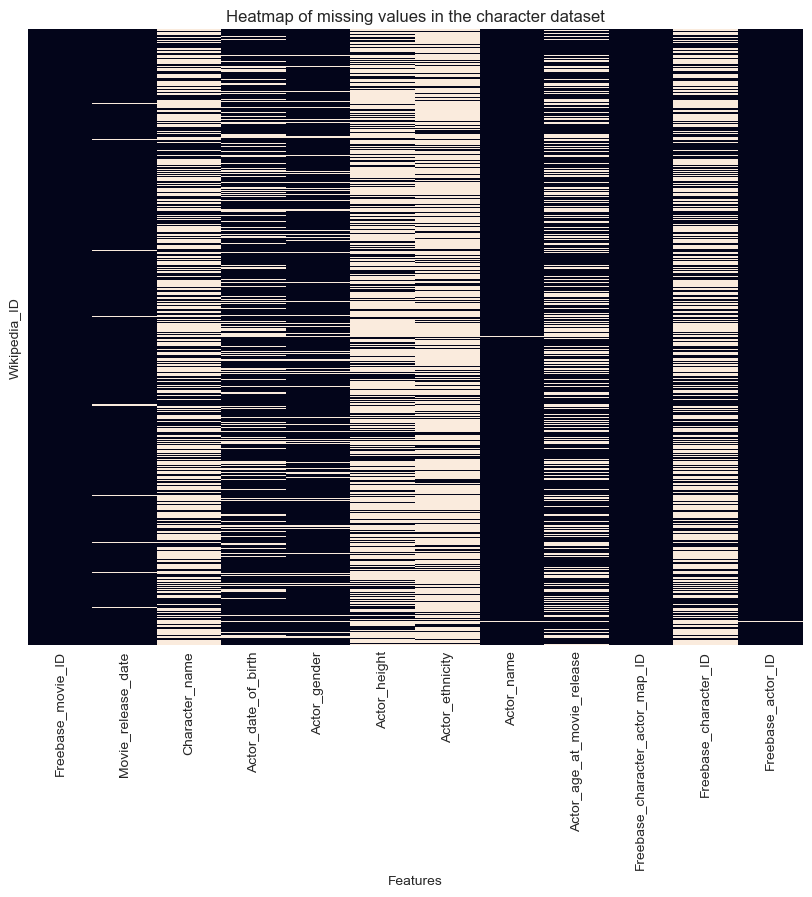

In [903]:
fig, ax = plt.subplots(figsize=(10,8)) 
sns.heatmap(character_metadata.isna(), yticklabels=False, cbar=False)
ax.set(xlabel="Features", ylabel="Wikipedia_ID")
ax.set_title('Heatmap of missing values in the character dataset')
print('Sum of NaN in each feature : ')
character_metadata.isna().sum(axis = 0)

The white lines stand for missing values.

In [904]:
n_char=len(character_metadata)
print('Percentage of missing entries in the character.metadata dataset:\n', 100*character_metadata[['Freebase_movie_ID', 'Movie_release_date', 'Character_name',
                                                                                   'Actor_date_of_birth', 'Actor_gender', 'Actor_height', 'Actor_ethnicity',
                                                                                   'Actor_name', 'Actor_age_at_movie_release', 'Freebase_character_ID',
                                                                                   'Freebase_actor_ID']].isna().sum() / n_char)

Percentage of missing entries in the character.metadata dataset:
 Freebase_movie_ID              0.000000
Movie_release_date             2.217814
Character_name                57.220488
Actor_date_of_birth           23.552763
Actor_gender                  10.120288
Actor_height                  65.645740
Actor_ethnicity               76.466542
Actor_name                     0.272484
Actor_age_at_movie_release    35.084064
Freebase_character_ID         57.218269
Freebase_actor_ID              0.180842
dtype: float64


We are missing a lot of data on actor's and actresses' ethnicities and their heights. This should not affect our analysis a we did not plan on using these features initially. For the other features we need to figure out if they are relevant to our analysis, and if so, need to decide wheter we want to discard the rows containing NaNs or try and find the information elsewhere.

In [905]:
character_dropna = character_metadata.dropna()
character_dropna.head()

Freebase_movie_ID Movie_release_date  \
Wikipedia_movie_ID                                        
975900                     /m/03vyhn         2001-08-24   
975900                     /m/03vyhn         2001-08-24   
975900                     /m/03vyhn         2001-08-24   
2314463                    /m/0734w5               2006   
612710                     /m/02wjqm         1999-10-01   

                                Character_name Actor_date_of_birth  \
Wikipedia_movie_ID                                                   
975900              Lieutenant Melanie Ballard          1974-08-15   
975900                     Desolation Williams          1969-06-15   
975900               Commander Helena Braddock          1949-05-26   
2314463                              Taper Guy          1971-05-26   
612710                                  Sandii          1975-09-20   

                   Actor_gender  Actor_height Actor_ethnicity  \
Wikipedia_movie_ID                                              
975900                        F         1.780      /m/044038p   
975900                        M         1.727         /m/0x67   
975900                        F         1.727         /m/0x67   
2314463                       M         1.870       /m/033tf_   
612710                        F         1.680       /m/0222qb   

                            Actor_name  Actor_age_at_movie_release  \
Wikipedia_movie_ID                                                   
975900              Natasha Henstridge                        27.0   
975900                        Ice Cube                        32.0   
975900                       Pam Grier                        52.0   
2314463                     Matt Stone                        34.0   
612710                    Asia Argento                        24.0   

                   Freebase_character_actor_map_ID Freebase_character_ID  \
Wikipedia_movie_ID                                                         
975900                                   /m/0jys3m            /m/0bgchn4   
975900                                   /m/0jys3g            /m/0bgchn_   
975900                                  /m/02vdcfp            /m/0bgchnd   
2314463                                 /m/0cgn0lx            /m/0h0z488   
612710                                  /m/02vcxk_            /m/0h2l6rx   

                   Freebase_actor_ID  
Wikipedia_movie_ID                    
975900                     /m/0346l4  
975900                    /m/01vw26l  
975900                     /m/0418ft  
2314463                    /m/01_x6d  
612710                     /m/028pzq

In [906]:
n_movie = len(movie_metadata)
n_summaries = len(plot_summaries)
n_char = len(character_metadata)
n_name_clusters = len(name_clusters)
n_tropes_clusters = len(tv_tropes_clusters)
n_appr = len(movie_appreciation_metadata)
n_osc = len(movie_oscar_winners)

print('Number of rows in the movie.metadata dataset : %d' %n_movie)
print('Number of rows in the plot_summaries dataset : %d' %n_summaries)
print('Number of rows in the character.metadata dataset : %d' %n_char)
print('Number of rows in the name.clusters dataset : %d' %n_name_clusters)
print('Number of rows in the movie_appreciation_metadata dataset : %d' %n_appr)
print('Number of rows in the movie_oscar_winners dataset : %d' %n_osc)

Number of rows in the movie.metadata dataset : 81741
Number of rows in the plot_summaries dataset : 42303
Number of rows in the character.metadata dataset : 450669
Number of rows in the name.clusters dataset : 2666
Number of rows in the movie_appreciation_metadata dataset : 5043
Number of rows in the movie_oscar_winners dataset : 9964


In [907]:
print("What is needed to be processed:")
print("Rows with actor age at movie release under or equal to 0: %d" %len(character_metadata[character_metadata['Actor_age_at_movie_release']<=0]))
print("Rows with actor height under or equal to 0: %d" %len(character_metadata[character_metadata['Actor_height']<=0]))
print("Rows with movie runtime under or equal to 0: %d" %len(movie_metadata[movie_metadata['Movie_runtime']<=0]))
character_metadata

What is needed to be processed:
Rows with actor age at movie release under or equal to 0: 433
Rows with actor height under or equal to 0: 0
Rows with movie runtime under or equal to 0: 1


Freebase_movie_ID Movie_release_date  \
Wikipedia_movie_ID                                        
975900                     /m/03vyhn         2001-08-24   
975900                     /m/03vyhn         2001-08-24   
975900                     /m/03vyhn         2001-08-24   
975900                     /m/03vyhn         2001-08-24   
975900                     /m/03vyhn         2001-08-24   
...                              ...                ...   
913762                     /m/03pcrp         1992-05-21   
913762                     /m/03pcrp         1992-05-21   
28308153                  /m/0cp05t9               1957   
28308153                  /m/0cp05t9               1957   
28308153                  /m/0cp05t9               1957   

                                Character_name Actor_date_of_birth  \
Wikipedia_movie_ID                                                   
975900                                Akooshay          1958-08-26   
975900              Lieutenant Melanie Ballard          1974-08-15   
975900                     Desolation Williams          1969-06-15   
975900                      Sgt Jericho Butler          1967-09-12   
975900                         Bashira Kincaid          1977-09-25   
...                                        ...                 ...   
913762                                  Elensh             1970-05   
913762                                  Hibiki          1965-04-12   
28308153                                   NaN          1941-11-18   
28308153                                   NaN                 NaN   
28308153                                   NaN                 NaN   

                   Actor_gender  Actor_height Actor_ethnicity  \
Wikipedia_movie_ID                                              
975900                        F         1.620             NaN   
975900                        F         1.780      /m/044038p   
975900                        M         1.727         /m/0x67   
975900                        M         1.750             NaN   
975900                        F         1.650             NaN   
...                         ...           ...             ...   
913762                        F           NaN             NaN   
913762                        M           NaN             NaN   
28308153                      M         1.730       /m/02w7gg   
28308153                    NaN           NaN             NaN   
28308153                    NaN           NaN             NaN   

                            Actor_name  Actor_age_at_movie_release  \
Wikipedia_movie_ID                                                   
975900                  Wanda De Jesus                        42.0   
975900              Natasha Henstridge                        27.0   
975900                        Ice Cube                        32.0   
975900                   Jason Statham                        33.0   
975900                     Clea DuVall                        23.0   
...                                ...                         ...   
913762              Dorothy Elias-Fahn                         NaN   
913762                   Jonathan Fahn                        27.0   
28308153                David Hemmings                        15.0   
28308153              Roberta Paterson                         NaN   
28308153                   John Rogers                         NaN   

                   Freebase_character_actor_map_ID Freebase_character_ID  \
Wikipedia_movie_ID                                                         
975900                                  /m/0bgchxw            /m/0bgcj3x   
975900                                   /m/0jys3m            /m/0bgchn4   
975900                                   /m/0jys3g            /m/0bgchn_   
975900                                  /m/02vchl6            /m/0bgchnq   
975900                                  /m/02vbb3r            /m/0bgchp9   
...                                            ... 

In [908]:
#putting the absolute value for the actor's ages that are negative
character_metadata['Actor_age_at_movie_release']=character_metadata['Actor_age_at_movie_release'].abs()

In [909]:
#dropping the actor ages and movie runtimes that are equal to zero
character_metadata.drop(character_metadata[character_metadata['Actor_age_at_movie_release']==0].index, inplace=True)
movie_metadata.drop(movie_metadata[movie_metadata['Movie_runtime']==0].index, inplace=True)

We check for duplicated rows in the `plot_summaries` dataset and the `character.metadata` dataset as we don't want duplicates. We do not need to check for specific features duplicated as it could be possible and would not be a problem

In [910]:
print("Duplicated rows in the plot_summaries dataset : {}".format(plot_summaries.duplicated().sum()))
print("Duplicated rows in character.metadata dataset : {}".format(character_metadata.duplicated().sum()))

Duplicated rows in the plot_summaries dataset : 8
Duplicated rows in character.metadata dataset : 0


For the `movie_ metadata` dataset, we need to check duplicated depending on rows. As we don't want for example the same movie with different Movie release dates, or different Freebase movie IDs.

In [911]:

#Looking for duplicates in our datasets
for f in movie_metadata.columns:
    dupl = movie_metadata[f].duplicated().sum()
    print("{} has {} duplicated rows".format(f, dupl))

Freebase_movie_ID has 0 duplicated rows
Movie_name has 6263 duplicated rows
Movie_release_date has 61350 duplicated rows
Movie_box_office_revenue has 74377 duplicated rows
Movie_runtime has 81143 duplicated rows
Movie_languages has 79923 duplicated rows
Movie_countries has 79616 duplicated rows
Movie_genres has 57923 duplicated rows


We can see that there are 6263 movies with the same title. This could be concerning. However, as no movie has the same Wikipedia movie ID or Freebase movie ID, we could assume that these title duplications are only movies with the same title and not the same movie just duplicated.

In [912]:
#one movie has a release year that is obviously false 
movie_metadata[movie_metadata["Movie_name"]=="Hunting Season"]

Freebase_movie_ID      Movie_name Movie_release_date  \
Wikipedia_movie_ID                                                        
29666067                  /m/0fphzrf  Hunting Season         1010-12-02   

                    Movie_box_office_revenue  Movie_runtime  \
Wikipedia_movie_ID                                            
29666067                          12160978.0          140.0   

                                         Movie_languages Movie_countries  \
Wikipedia_movie_ID                                                         
29666067            [Turkish Language, English Language]        [Turkey]   

                                                 Movie_genres  
Wikipedia_movie_ID                                             
29666067            [Crime Fiction, Mystery, Drama, Thriller]

We can see that the release date of this movie is wrong. 1010-12-02 should be 2010-12-02. We correct this.

In [913]:
movie_metadata.loc[movie_metadata['Movie_release_date'] == '1010-12-02','Movie_release_date'] = '2010-12-02'

In [914]:
movie_metadata[movie_metadata["Movie_name"]=="Hunting Season"]

Freebase_movie_ID      Movie_name Movie_release_date  \
Wikipedia_movie_ID                                                        
29666067                  /m/0fphzrf  Hunting Season         2010-12-02   

                    Movie_box_office_revenue  Movie_runtime  \
Wikipedia_movie_ID                                            
29666067                          12160978.0          140.0   

                                         Movie_languages Movie_countries  \
Wikipedia_movie_ID                                                         
29666067            [Turkish Language, English Language]        [Turkey]   

                                                 Movie_genres  
Wikipedia_movie_ID                                             
29666067            [Crime Fiction, Mystery, Drama, Thriller]

We see that some of the Movie release dates only contain the year and not the full year-month-day date so we correct this to have a standardized way of having our Movie release dates.

In [915]:
#Adding 01-01-Year for movies only including a year for the dates
movie_metadata["Movie_release_date"] = pd.to_datetime(movie_metadata["Movie_release_date"],errors='coerce') 
movie_metadata.head()

Freebase_movie_ID  \
Wikipedia_movie_ID                     
975900                     /m/03vyhn   
3196793                    /m/08yl5d   
28463795                  /m/0crgdbh   
9363483                   /m/0285_cd   
261236                     /m/01mrr1   

                                                           Movie_name  \
Wikipedia_movie_ID                                                      
975900                                                 Ghosts of Mars   
3196793             Getting Away with Murder: The JonBenét Ramsey ...   
28463795                                                  Brun bitter   
9363483                                              White Of The Eye   
261236                                              A Woman in Flames   

                   Movie_release_date  Movie_box_office_revenue  \
Wikipedia_movie_ID                                                
975900                     2001-08-24                14010832.0   
3196793                    2000-02-16                       NaN   
28463795                   1988-01-01                       NaN   
9363483                    1987-01-01                       NaN   
261236                     1983-01-01                       NaN   

                    Movie_runtime       Movie_languages  \
Wikipedia_movie_ID                                        
975900                       98.0    [English Language]   
3196793                      95.0    [English Language]   
28463795                     83.0  [Norwegian Language]   
9363483                     110.0    [English Language]   
261236                      106.0     [German Language]   

                               Movie_countries  \
Wikipedia_movie_ID                               
975900              [United States of America]   
3196793             [United States of America]   
28463795                              [Norway]   
9363483                       [United Kingdom]   
261236                               [Germany]   

                                                         Movie_genres  
Wikipedia_movie_ID                                                     
975900              [Thriller, Science Fiction, Horror, Adventure,...  
3196793              [Mystery, Biographical film, Drama, Crime Drama]  
28463795                                       [Crime Fiction, Drama]  
9363483             [Thriller, Erotic thriller, Psychological thri...  
261236                                                        [Drama]

We can see that the release date of this movie is wrong. 1010-12-02 should be 2010-12-03.

The last film in our dataframe was released in 2016 and the first one in 1888


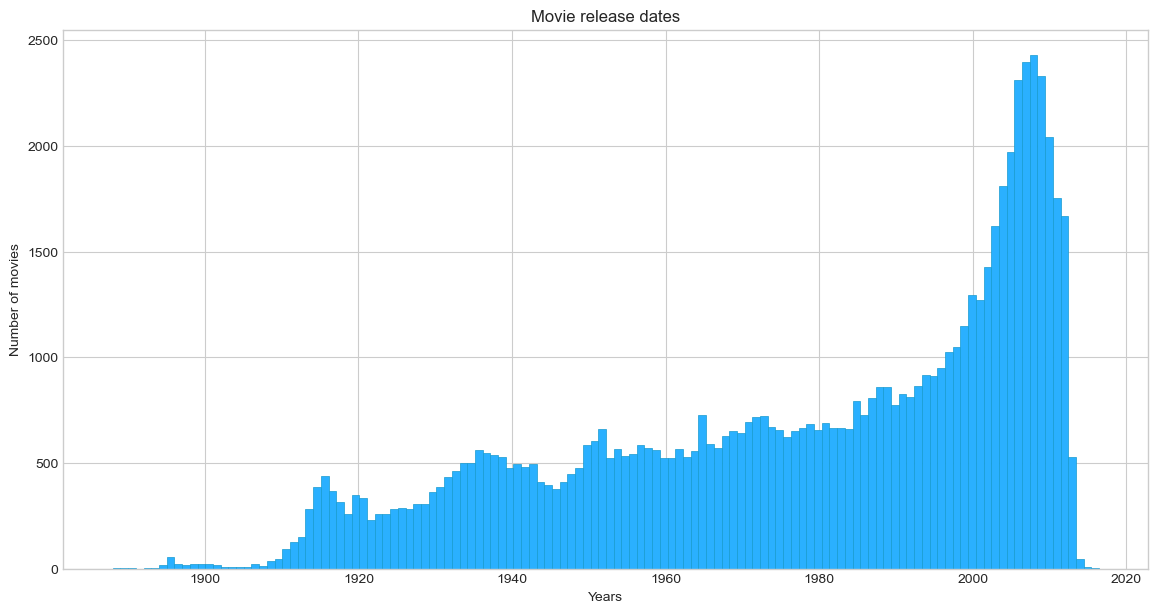

In [916]:
print('The last film in our dataframe was released in', movie_metadata.Movie_release_date.max().year,'and the first one in',movie_metadata.Movie_release_date.min().year)
num_years=(movie_metadata.Movie_release_date.max().year-movie_metadata.Movie_release_date.min().year)

plt.figure(figsize=(14,7))
plt.style.use('seaborn-whitegrid')
plt.hist(movie_metadata['Movie_release_date'],bins=num_years, facecolor = '#2ab0ff', edgecolor='#169acf', linewidth=0.5)
plt.title('Movie release dates') 
plt.xlabel('Years') 
plt.ylabel('Number of movies') 
plt.show()

As we can see the first film seems to have been released in 1888, it is in fact a short sequence of less than 3 seconds. But for our analysis it isn't releavant. Even if there is a debate on which is the fisrt "real movie" we will consider that it is "A trip to the Moon", which is often taught at school. So we will consider movies starting from 1902, and this seems relevant in view of the plot above! 

Source: https://www.studiobinder.com/blog/what-was-the-first-movie-ever-made/

In [917]:
movie_metadata=movie_metadata[~(movie_metadata['Movie_release_date'] <= '1902-01-01')]


## B. Other datatsets pre-processing <a id="#Other_ds"> </a>

`movie_appreciation_metadata.tsv`

In [918]:
movie_appreciation_metadata.isna().any()

movie_title                  False
director name                 True
duration                      True
country                       True
actor_1_name                  True
actor_2_name                  True
actor_3_name                  True
movie_facebook_likes         False
actor_1_facebook_likes        True
actor_2_facebook_likes        True
actor_3_facebook_likes        True
director_facebook_likes       True
gross                         True
genres                       False
num_voted_users              False
cast_total_facebook_likes    False
facenumber_in_poster          True
num_user_for_reviews          True
content_rating                True
budget                        True
title_year                    True
imdb_score                   False
aspect_ratio                  True
dtype: bool

Sum of NaN in each feature : 


movie_title                     0
director name                5043
duration                       15
country                         5
actor_1_name                    7
actor_2_name                   13
actor_3_name                   23
movie_facebook_likes            0
actor_1_facebook_likes          7
actor_2_facebook_likes         13
actor_3_facebook_likes         23
director_facebook_likes       104
gross                         884
genres                          0
num_voted_users                 0
cast_total_facebook_likes       0
facenumber_in_poster           13
num_user_for_reviews           21
content_rating                303
budget                        492
title_year                    108
imdb_score                      0
aspect_ratio                  329
dtype: int64

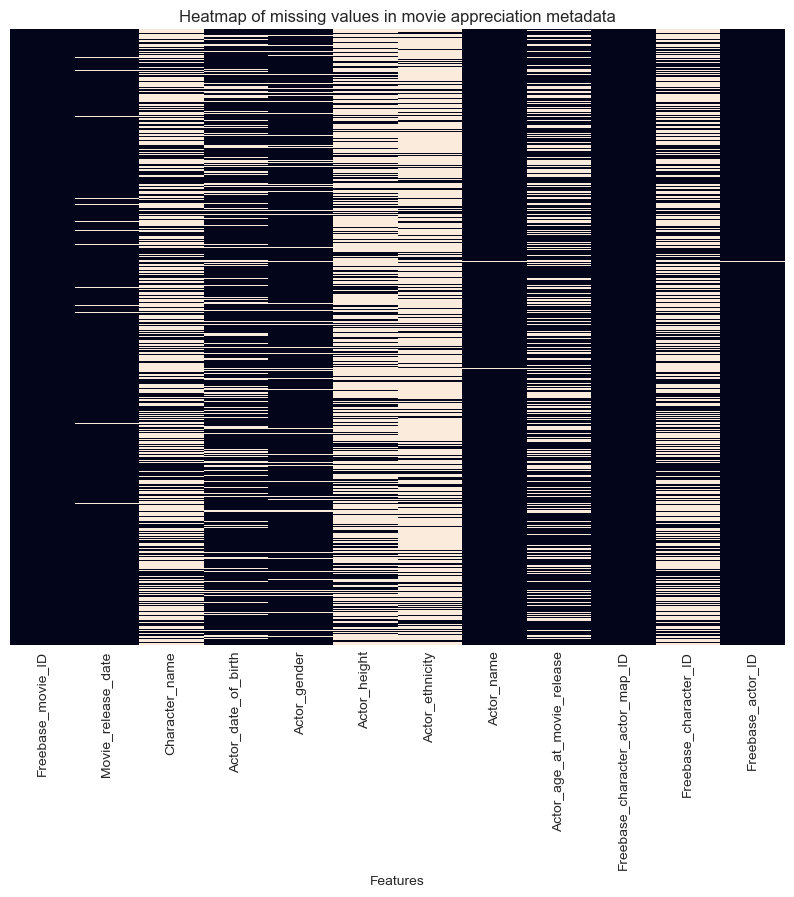

In [919]:
fig, ax = plt.subplots(figsize=(10,8)) 
sns.heatmap(character_metadata.isna(), yticklabels=False, cbar=False)
ax.set(xlabel="Features", ylabel="")
ax.set_title('Heatmap of missing values in movie appreciation metadata')
print('Sum of NaN in each feature : ')
movie_appreciation_metadata.isna().sum(axis = 0)

`oscar_winners.csv`

In [920]:
movie_oscar_winners.isna().any()

Year        False
Ceremony    False
Award       False
Winner       True
Name        False
Film         True
dtype: bool

We do not consider the column 'winner' as it contains indicators (1 and 0) to check wether a movie, an actor or a director has won the oscar. 

Sum of NaN in each feature : 


Year          0
Ceremony      0
Award         0
Name          0
Film        333
dtype: int64

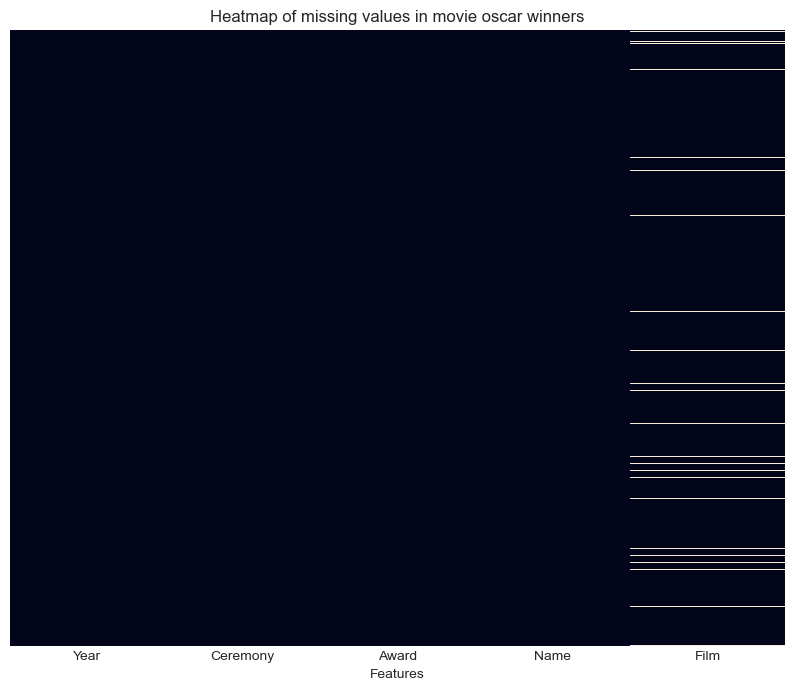

In [921]:
fig, ax = plt.subplots(figsize=(10,8)) 
sns.heatmap(movie_oscar_winners[['Year','Ceremony','Award','Name','Film']].isna(), yticklabels=False, cbar=False)
ax.set(xlabel="Features", ylabel="")
ax.set_title('Heatmap of missing values in movie oscar winners')
print('Sum of NaN in each feature : ')

movie_oscar_winners[['Year','Ceremony','Award','Name','Film']].isna().sum(axis = 0)

`title.basics.tsv`

In [922]:
IMDb_basics=IMDb_basics.drop_duplicates()
IMDb_basics.isna().any()

titleType        False
primaryTitle      True
originalTitle     True
startYear        False
genres            True
dtype: bool

`title.ratings.tsv`

In [923]:
IMDb_ratings=IMDb_ratings.drop_duplicates()
IMDb_ratings=IMDb_ratings.dropna()
IMDb_ratings.isna().any()
print('The length of the IMDb ratings dataset is', len(IMDb_ratings))

The length of the IMDb ratings dataset is 119899


To obtain the dataset with ratings and the associated movie titles, we merge the IMDb_basics dataset with the IMDb_ratings dataset.

In [924]:
IMDb_ratings=IMDb_ratings.merge(IMDb_basics, on='tconst', how='left').dropna()


The dataset IMDb-ratings after merging with IMDb_basics is the one we are going to use in part 3.C. We decide to only consider the original title as the title of the film, and to drop the primary title.

In [925]:
IMDb_ratings = IMDb_ratings.drop(['primaryTitle'], axis=1)
IMDb_ratings = IMDb_ratings.rename(columns={'tconst': 'IMDb_ID', 'averageRating': 'IMDb_rating', 'numVotes': 'IMDb_votes', 'originalTitle':'Movie_name','startYear': 'Movie_release_year', 'runtimeMinutes': 'Movie_runtime', 'genres': 'Movie_genres'})

We only keep movies from after 1902.

In [926]:
# only keep rows where titleType = 'movie'
IMDb_ratings = IMDb_ratings[IMDb_ratings['titleType'] == 'movie']
IMDb_ratings = IMDb_ratings[~(IMDb_ratings['Movie_release_year'] <= '1902')]

In [927]:
IMDb_ratings

IMDb_rating  IMDb_votes titleType                      Movie_name  \
tconst                                                                         
tt0000502          4.2          14     movie                        Bohemios   
tt0000574          6.0         797     movie     The Story of the Kelly Gang   
tt0000591          5.1          20     movie               L'enfant prodigue   
tt0000615          4.3          23     movie              Robbery Under Arms   
tt0000630          2.9          25     movie                          Amleto   
...                ...         ...       ...                             ...   
tt9902160          7.0        3885     movie                         Herself   
tt9904802          4.5        1726     movie                     Enemy Lines   
tt9907782          6.2       11447     movie                Eight for Silver   
tt9911196          7.5        3554     movie  De beentjes van Sint-Hildegard   
tt9916270          5.8        1378     movie        Il talento del calabrone   

          Movie_release_year                Movie_genres  
tconst                                                    
tt0000502               1905                          \N  
tt0000574               1906  Action,Adventure,Biography  
tt0000591               1907                       Drama  
tt0000615               1907                       Drama  
tt0000630               1908                       Drama  
...                      ...                         ...  
tt9902160               2020                       Drama  
tt9904802               2020                         War  
tt9907782               2021      Fantasy,Horror,Mystery  
tt9911196               2020                Comedy,Drama  
tt9916270               2020                    Thriller  

[62072 rows x 6 columns]

## C. First insights on gender gap <a id="First_insights"> </a>

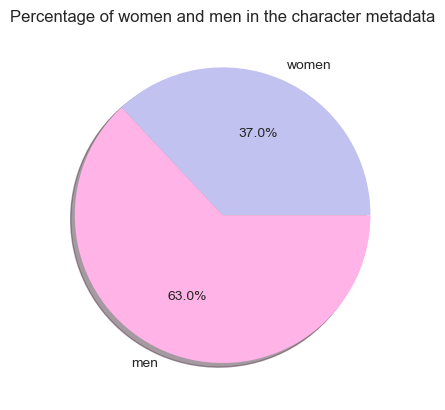

In [928]:
#Plotting on a pie chart the percentage of women and men in the character metadata
fem_act = character_metadata[character_metadata['Actor_gender'] == 'F']
masc_act = character_metadata[character_metadata['Actor_gender'] == 'M']
plt.pie(np.array([fem_act['Actor_name'].nunique(),masc_act['Actor_name'].nunique()]),labels=['women','men'],colors = ['#c2c2f0','#ffb3e6'],autopct='%1.1f%%',shadow=True)
plt.title('Percentage of women and men in the character metadata')
plt.show()

In [929]:
#replace NaN values with 0
character_metadata_clean = character_metadata.fillna(0)
movie_metadata_clean = movie_metadata.fillna(0)

In [930]:
#new dataframe with movies after 2007 after converting the release date to datetime some dates are only year so we need to add the month and day

movie_metadata_clean['Movie_release_date'] = pd.to_datetime(movie_metadata_clean['Movie_release_date'],errors='coerce')
movie_metadata_clean = movie_metadata_clean[movie_metadata_clean['Movie_release_date'] > datetime(2007,1,1)]
movie_metadata_clean.head()

Freebase_movie_ID                    Movie_name  \
Wikipedia_movie_ID                                                   
21926710                  /m/05p45cv                 White on Rice   
20604092                  /m/0523t_1                   Anbu Thozhi   
29772142                  /m/0fq260_  Karayilekku Oru Kadal Dooram   
26623942                  /m/0bh9fbk                   Kausthubham   
32445576                  /m/0gyv1h1      Vinayaka Geleyara Balaga   

                   Movie_release_date  Movie_box_office_revenue  \
Wikipedia_movie_ID                                                
21926710                   2009-01-01                       0.0   
20604092                   2007-08-17                       0.0   
29772142                   2010-12-31                       0.0   
26623942                   2010-03-19                       0.0   
32445576                   2011-07-15                       0.0   

                    Movie_runtime       Movie_languages  \
Wikipedia_movie_ID                                        
21926710                     82.0                    []   
20604092                      0.0      [Tamil Language]   
29772142                    110.0  [Malayalam Language]   
26623942                      0.0  [Malayalam Language]   
32445576                      0.0                    []   

                               Movie_countries  \
Wikipedia_movie_ID                               
21926710            [United States of America]   
20604092                               [India]   
29772142                               [India]   
26623942                               [India]   
32445576                                    []   

                                                      Movie_genres  
Wikipedia_movie_ID                                                  
21926710            [Romantic comedy, Romance Film, Comedy, Indie]  
20604092                                            [Romance Film]  
29772142                                                   [Drama]  
26623942                                                   [Drama]  
32445576                                                        []

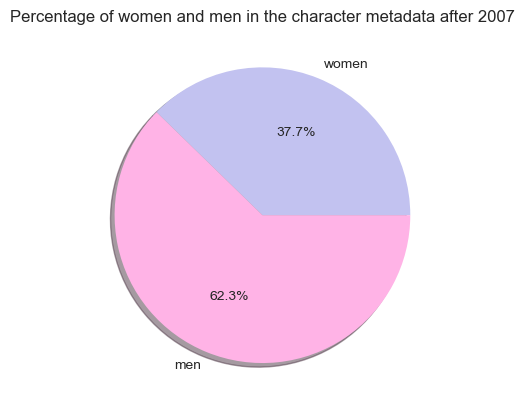

In [931]:
#only keep characters with 'wikipedia movie ID' in movie_metadata_clean after 2007
character_metadata_clean = character_metadata_clean[character_metadata_clean.index.isin(movie_metadata_clean.index)]
#number of female actors compared to male actors for movies after 2007 plotted in a pie chart
fem_act = character_metadata_clean[character_metadata_clean['Actor_gender'] == 'F']
masc_act = character_metadata_clean[character_metadata_clean['Actor_gender'] == 'M']
plt.pie(np.array([fem_act['Actor_name'].nunique(),masc_act['Actor_name'].nunique()]),labels=['women','men'],colors = ['#c2c2f0','#ffb3e6'],autopct='%1.1f%%',shadow=True)
plt.title('Percentage of women and men in the character metadata after 2007')
plt.show()

We can at least see that there's a small increase of 0.7% in the distribution for women on screen after 2007.

In [932]:
#merge character metadata with plot summaries

plot_summaries = plot_summaries.join(character_metadata, on='Wikipedia_movie_ID')
plot_summaries=plot_summaries.dropna()
plot_summaries.head()

Plot_Summary  \
Wikipedia_movie_ID                                                      
31186339            The nation of Panem consists of a wealthy Capi...   
31186339            The nation of Panem consists of a wealthy Capi...   
31186339            The nation of Panem consists of a wealthy Capi...   
31186339            The nation of Panem consists of a wealthy Capi...   
31186339            The nation of Panem consists of a wealthy Capi...   

                   Freebase_movie_ID Movie_release_date        Character_name  \
Wikipedia_movie_ID                                                              
31186339                  /m/0gkz15s         2012-03-12        Gale Hawthorne   
31186339                  /m/0gkz15s         2012-03-12     Caesar Flickerman   
31186339                  /m/0gkz15s         2012-03-12        President Snow   
31186339                  /m/0gkz15s         2012-03-12                 Cinna   
31186339                  /m/0gkz15s         2012-03-12  Claudius Templesmith   

                   Actor_date_of_birth Actor_gender  Actor_height  \
Wikipedia_movie_ID                                                  
31186339                    1990-01-13            M         1.910   
31186339                    1960-11-11            M         1.721   
31186339                    1935-07-17            M         1.930   
31186339                    1964-05-26            M         1.740   
31186339                    1966-09-07            M         1.650   

                   Actor_ethnicity         Actor_name  \
Wikipedia_movie_ID                                      
31186339                /m/0bbz66j     Liam Hemsworth   
31186339                  /m/0xnvg      Stanley Tucci   
31186339                 /m/07bch9  Donald Sutherland   
31186339                  /m/041rx      Lenny Kravitz   
31186339                  /m/0d7wh         Toby Jones   

                    Actor_age_at_movie_release  \
Wikipedia_movie_ID                               
31186339                                  22.0   
31186339                                  51.0   
31186339                                  76.0   
31186339                                  47.0   
31186339                                  45.0   

                   Freebase_character_actor_map_ID Freebase_character_ID  \
Wikipedia_movie_ID                                                         
31186339                                /m/0gw7kv7            /m/0ds96_p   
31186339                                /m/0gw7kw1            /m/0gwc3bn   
31186339                                /m/0gwc391            /m/0dsbx11   
31186339                                /m/0gw7kvx            /m/0gwc39n   
31186339                                /m/0j5lh7t            /m/0j5lh7x   

                   Freebase_actor_ID  
Wikipedia_movie_ID                    
31186339                  /m/04yd0fh  
31186339                   /m/02bj6k  
31186339                    /m/0ywqc  
31186339                   /m/0161sp  
31186339                   /m/071ywj

/var/folders/f4/b7ft2_n14dsbh5_k5kt37m0m0000gn/T/ipykernel_1502/1070814605.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_summaries_new['Movie_release_date'] = pd.to_datetime(plot_summaries_new['Movie_release_date'],errors='coerce')
/var/folders/f4/b7ft2_n14dsbh5_k5kt37m0m0000gn/T/ipykernel_1502/1070814605.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_summaries_new['Movie_release_date'] = plot_summaries_new['Movie_release_date'].dt.year
/var/folders/f4/b7ft2_n14dsbh5_k5kt37m0m0000gn/T/i

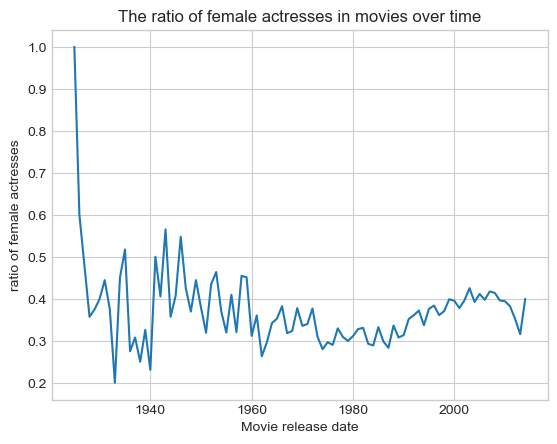

In [933]:
#create new dataframe where we change movie release date to datetime in plot_summaries
plot_summaries_new = plot_summaries[['Freebase_movie_ID', 'Movie_release_date','Actor_gender']]
plot_summaries_new['Movie_release_date'] = pd.to_datetime(plot_summaries_new['Movie_release_date'],errors='coerce')
plot_summaries_new['Movie_release_date'] = plot_summaries_new['Movie_release_date'].dt.year
plot_summaries_new
#calculate the number of 'F' for every 'Movie release date'
plot_summaries_new = plot_summaries_new.groupby(['Movie_release_date','Actor_gender']).size().reset_index(name='counts')
plot_summaries_new[170:180]
#add the total counts for every 'Movie release date'
plot_summaries_new['total_counts'] = plot_summaries_new.groupby('Movie_release_date')['counts'].transform('sum')
plot_summaries_new
#find the ratio of 'F' counts to total counts for every 'Movie release date'
plot_summaries_new['ratio'] = plot_summaries_new.groupby('Movie_release_date')['counts'].apply(lambda x: x/x.sum())
plot_summaries_new
#only keep the 'F' rows
plot_summaries_new = plot_summaries_new[plot_summaries_new['Actor_gender'] == 'F']
plot_summaries_new
#plot the 'Movie release date' and 'ratio' in a line graph
plt.plot(plot_summaries_new['Movie_release_date'], plot_summaries_new['ratio'])
plt.xlabel('Movie release date')
plt.ylabel('ratio of female actresses')
plt.title('The ratio of female actresses in movies over time')
plt.show()

We can interpret from the graph that the ratio of female actresses is clearly lower than half in the years between 1930 and 2010s where the data is most relevant. So actresses are less present than actors in the movies' main characters. We will keep on analysing this data in the next milestone.

 ---
# 2. Salaries, box office revenues, etc. <a id="Box_Office"> </a>

The gender gap is often referred to as the gender pay gap. This is why our first axis of analysis was done from a financial view.

We start out by visualizing and analyzing what we know about box office revenues.

In [934]:
print("Movies with biggest box office revenues:")
movie_metadata.sort_values('Movie_box_office_revenue', ascending = False).head()

Movies with biggest box office revenues:


Freebase_movie_ID  \
Wikipedia_movie_ID                     
4273140                    /m/0bth54   
52371                       /m/0dr_4   
22114132                  /m/062zm5h   
31941988                  /m/0gvsynb   
25001260                  /m/0872p_c   

                                                       Movie_name  \
Wikipedia_movie_ID                                                  
4273140                                                    Avatar   
52371                                                     Titanic   
22114132                                             The Avengers   
31941988            Harry Potter and the Deathly Hallows – Part 2   
25001260                           Transformers: Dark of the Moon   

                   Movie_release_date  Movie_box_office_revenue  \
Wikipedia_movie_ID                                                
4273140                    2009-12-10              2.782275e+09   
52371                      1997-11-01              2.185372e+09   
22114132                   2012-04-11              1.511758e+09   
31941988                   2011-07-07              1.328111e+09   
25001260                   2011-06-23              1.123747e+09   

                    Movie_runtime  \
Wikipedia_movie_ID                  
4273140                     178.0   
52371                       194.0   
22114132                    137.0   
31941988                    130.0   
25001260                    157.0   

                                                      Movie_languages  \
Wikipedia_movie_ID                                                      
4273140                          [English Language, Spanish Language]   
52371               [Italian Language, English Language, French La...   
22114132                         [Russian Language, English Language]   
31941988                                           [English Language]   
25001260                                           [English Language]   

                                               Movie_countries  \
Wikipedia_movie_ID                                               
4273140             [United States of America, United Kingdom]   
52371                               [United States of America]   
22114132                            [United States of America]   
31941988            [United States of America, United Kingdom]   
25001260                            [United States of America]   

                                                         Movie_genres  
Wikipedia_movie_ID                                                     
4273140             [Thriller, Science Fiction, Adventure, Compute...  
52371               [Tragedy, Costume drama, Historical fiction, A...  
22114132                                    [Science Fiction, Action]  
31941988                         [Drama, Mystery, Fantasy, Adventure]  
25001260             [Alien Film, Science Fiction, Action, Adventure]

In [935]:
print("{:.2%} of the movies have a missing movie box office revenue value".format(movie_metadata.isnull().sum()['Movie_box_office_revenue']/len(movie_metadata)))

89.70% of the movies have a missing movie box office revenue value


As we see above, a lot of the data on the movie box office revenue is missing. This could be problematic as our analysis will focus solely on a partial amount of our dataset. It might make more sense to look at some kind of rating, such ad IMDb rating, to assess whether the movie was successful or not and to try to make sense of how gender is linked to the success of movies.

In [936]:
#Find movies without box office revenue and filter them out
no_rev = movie_metadata.loc[movie_metadata['Movie_box_office_revenue'].isnull()].index
movie_metadata_filt = movie_metadata.drop(no_rev)
movie_metadata_filt['Movie_release_date'] = pd.to_datetime(movie_metadata_filt['Movie_release_date'],errors='coerce')

In [937]:
movie_metadata.shape[0]

81529

In [938]:
movie_metadata_filt.shape[0]

8400

We only have 8401 movies where we have their box office revenue.

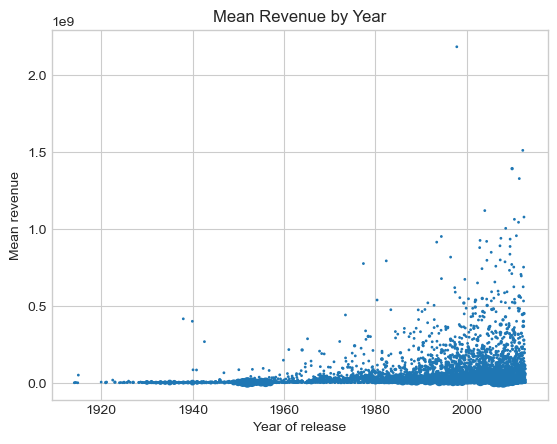

In [939]:
revenue_year = movie_metadata_filt.groupby("Movie_release_date")['Movie_box_office_revenue'].agg(['mean','size']).reset_index()
revenue_year.plot(kind = 'scatter', x = 'Movie_release_date', y = 'mean',s = 'size')
plt.title('Mean Revenue by Year')
plt.ylabel('Mean revenue')
plt.xlabel('Year of release')
plt.show()

From the movies which we have the box office revenue of, we observe a tendency to rise along the years. This is easily explained by the fact that the movie industry has grown over the years and that it generates more and more money through the years.

In [940]:
display(character_metadata.head())
display(movie_metadata.head())

Freebase_movie_ID Movie_release_date  \
Wikipedia_movie_ID                                        
975900                     /m/03vyhn         2001-08-24   
975900                     /m/03vyhn         2001-08-24   
975900                     /m/03vyhn         2001-08-24   
975900                     /m/03vyhn         2001-08-24   
975900                     /m/03vyhn         2001-08-24   

                                Character_name Actor_date_of_birth  \
Wikipedia_movie_ID                                                   
975900                                Akooshay          1958-08-26   
975900              Lieutenant Melanie Ballard          1974-08-15   
975900                     Desolation Williams          1969-06-15   
975900                      Sgt Jericho Butler          1967-09-12   
975900                         Bashira Kincaid          1977-09-25   

                   Actor_gender  Actor_height Actor_ethnicity  \
Wikipedia_movie_ID                                              
975900                        F         1.620             NaN   
975900                        F         1.780      /m/044038p   
975900                        M         1.727         /m/0x67   
975900                        M         1.750             NaN   
975900                        F         1.650             NaN   

                            Actor_name  Actor_age_at_movie_release  \
Wikipedia_movie_ID                                                   
975900                  Wanda De Jesus                        42.0   
975900              Natasha Henstridge                        27.0   
975900                        Ice Cube                        32.0   
975900                   Jason Statham                        33.0   
975900                     Clea DuVall                        23.0   

                   Freebase_character_actor_map_ID Freebase_character_ID  \
Wikipedia_movie_ID                                                         
975900                                  /m/0bgchxw            /m/0bgcj3x   
975900                                   /m/0jys3m            /m/0bgchn4   
975900                                   /m/0jys3g            /m/0bgchn_   
975900                                  /m/02vchl6            /m/0bgchnq   
975900                                  /m/02vbb3r            /m/0bgchp9   

                   Freebase_actor_ID  
Wikipedia_movie_ID                    
975900                    /m/03wcfv7  
975900                     /m/0346l4  
975900                    /m/01vw26l  
975900                     /m/034hyc  
975900                     /m/01y9xg

Freebase_movie_ID  \
Wikipedia_movie_ID                     
975900                     /m/03vyhn   
3196793                    /m/08yl5d   
28463795                  /m/0crgdbh   
9363483                   /m/0285_cd   
261236                     /m/01mrr1   

                                                           Movie_name  \
Wikipedia_movie_ID                                                      
975900                                                 Ghosts of Mars   
3196793             Getting Away with Murder: The JonBenét Ramsey ...   
28463795                                                  Brun bitter   
9363483                                              White Of The Eye   
261236                                              A Woman in Flames   

                   Movie_release_date  Movie_box_office_revenue  \
Wikipedia_movie_ID                                                
975900                     2001-08-24                14010832.0   
3196793                    2000-02-16                       NaN   
28463795                   1988-01-01                       NaN   
9363483                    1987-01-01                       NaN   
261236                     1983-01-01                       NaN   

                    Movie_runtime       Movie_languages  \
Wikipedia_movie_ID                                        
975900                       98.0    [English Language]   
3196793                      95.0    [English Language]   
28463795                     83.0  [Norwegian Language]   
9363483                     110.0    [English Language]   
261236                      106.0     [German Language]   

                               Movie_countries  \
Wikipedia_movie_ID                               
975900              [United States of America]   
3196793             [United States of America]   
28463795                              [Norway]   
9363483                       [United Kingdom]   
261236                               [Germany]   

                                                         Movie_genres  
Wikipedia_movie_ID                                                     
975900              [Thriller, Science Fiction, Horror, Adventure,...  
3196793              [Mystery, Biographical film, Drama, Crime Drama]  
28463795                                       [Crime Fiction, Drama]  
9363483             [Thriller, Erotic thriller, Psychological thri...  
261236                                                        [Drama]

We merge our character_metadata dataset and our movie_metadata dataset to try and visualize the difference in box office revenues according to the differenct actor's genders.
We do an inner join because there are movies in the movie_metadata dataset for which we do not have any information on the characters in character_metadata and vice versa.
For further analysis, we need information about both the characters and the movies they appear in.

In [941]:
characters_movie=pd.merge(character_metadata,movie_metadata_filt,left_index=True,right_index=True,how="inner")
characters_movie['Movie_release_date_x'] = pd.to_datetime(characters_movie['Movie_release_date_x'],errors='coerce')
characters_movie.head()

Freebase_movie_ID_x Movie_release_date_x    Character_name  \
Wikipedia_movie_ID                                                              
3217                          /m/014hr           1992-10-09      S-Mart Clerk   
3217                          /m/014hr           1992-10-09        Fake shemp   
3217                          /m/014hr           1992-10-09      Ash Williams   
3217                          /m/014hr           1992-10-09          Evil Ash   
3217                          /m/014hr           1992-10-09  Cowardly Warrior   

                   Actor_date_of_birth Actor_gender  Actor_height  \
Wikipedia_movie_ID                                                  
3217                        1965-12-14            M          1.87   
3217                              1956            M           NaN   
3217                        1958-06-22            M          1.85   
3217                        1958-06-22            M          1.85   
3217                        1965-12-14            M          1.87   

                   Actor_ethnicity      Actor_name  \
Wikipedia_movie_ID                                   
3217                           NaN       Ted Raimi   
3217                           NaN      Ivan Raimi   
3217                           NaN  Bruce Campbell   
3217                           NaN  Bruce Campbell   
3217                           NaN       Ted Raimi   

                    Actor_age_at_movie_release  \
Wikipedia_movie_ID                               
3217                                      26.0   
3217                                      36.0   
3217                                      34.0   
3217                                      34.0   
3217                                      26.0   

                   Freebase_character_actor_map_ID Freebase_character_ID  \
Wikipedia_movie_ID                                                         
3217                                    /m/0hgcnkm            /m/0hgcnkq   
3217                                    /m/04hzm56             /m/089hc6   
3217                                     /m/0jtqtd             /m/06_krl   
3217                                    /m/0jtgxg0            /m/0jtgxg3   
3217                                    /m/04hzm5x            /m/0hgcnjh   

                   Freebase_actor_ID Freebase_movie_ID_y        Movie_name  \
Wikipedia_movie_ID                                                           
3217                        /m/07qn0            /m/014hr  Army of Darkness   
3217                       /m/0gmjf8            /m/014hr  Army of Darkness   
3217                        /m/01h8f            /m/014hr  Army of Darkness   
3217                        /m/01h8f            /m/014hr  Army of Darkness   
3217                        /m/07qn0            /m/014hr  Army of Darkness   

                   Movie_release_date_y  Movie_box_office_revenue  \
Wikipedia_movie_ID                                                  
3217                         1992-10-09                21502796.0   
3217                         1992-10-09                21502796.0   
3217                         1992-10-09                21502796.0   
3217                         1992-10-09                21502796.0   
3217                         1992-10-09                21502796.0   

                    Movie_runtime     Movie_languages  \
Wikipedia_movie_ID                                      
3217                         81.0  [English Language]   
3217                         81.0  [English Language]   
3217                         81.0  [English Language]   
3217                         81.0  [English Language]   
3217                         81.0  [English Language]   

                               Movie_countries  \
Wikipedia_movie_ID                               
3217                [United States of America]   
3217                [United States of America]   
3217                [United States of America]   
3217                [Un

In [942]:
characters_movie_F = characters_movie[characters_movie['Actor_gender'] == 'F']
characters_movie_M = characters_movie[characters_movie['Actor_gender'] == 'M']

In [943]:
display(characters_movie_F.head())
display(characters_movie_F.head())

Freebase_movie_ID_x Movie_release_date_x   Character_name  \
Wikipedia_movie_ID                                                             
3217                          /m/014hr           1992-10-09            Linda   
3217                          /m/014hr           1992-10-09           Sheila   
3217                          /m/014hr           1992-10-09  Possessed Witch   
3333                          /m/0151l           1915-01-01              NaN   
3333                          /m/0151l           1915-01-01              NaN   

                   Actor_date_of_birth Actor_gender  Actor_height  \
Wikipedia_movie_ID                                                  
3217                        1964-01-27            F          1.68   
3217                        1965-08-11            F          1.73   
3217                        1957-09-04            F          1.75   
3333                        1893-10-14            F          1.66   
3333                        1894-11-09            F          1.60   

                   Actor_ethnicity        Actor_name  \
Wikipedia_movie_ID                                     
3217                     /m/07hwkr     Bridget Fonda   
3217                     /m/06v41q    Embeth Davidtz   
3217                           NaN  Patricia Tallman   
3333                           NaN      Lillian Gish   
3333                           NaN         Mae Marsh   

                    Actor_age_at_movie_release  \
Wikipedia_movie_ID                               
3217                                      28.0   
3217                                      27.0   
3217                                      35.0   
3333                                       NaN   
3333                                       NaN   

                   Freebase_character_actor_map_ID Freebase_character_ID  \
Wikipedia_movie_ID                                                         
3217                                     /m/0jtqtq            /m/0h2hxrl   
3217                                     /m/0jtqtk            /m/0h36j9w   
3217                                    /m/04hzm5r            /m/0hgcnl6   
3333                                     /m/0k4hhp                   NaN   
3333                                     /m/0k4hh_                   NaN   

                   Freebase_actor_ID Freebase_movie_ID_y  \
Wikipedia_movie_ID                                         
3217                       /m/01yd8v            /m/014hr   
3217                       /m/034b7r            /m/014hr   
3217                       /m/045kf0            /m/014hr   
3333                       /m/01c2sl            /m/0151l   
3333                       /m/0735gw            /m/0151l   

                               Movie_name Movie_release_date_y  \
Wikipedia_movie_ID                                               
3217                     Army of Darkness           1992-10-09   
3217                     Army of Darkness           1992-10-09   
3217                     Army of Darkness           1992-10-09   
3333                The Birth of a Nation           1915-01-01   
3333                The Birth of a Nation           1915-01-01   

                    Movie_box_office_revenue  Movie_runtime  \
Wikipedia_movie_ID                                            
3217                              21502796.0           81.0   
3217                              21502796.0           81.0   
3217                              21502796.0           81.0   
3333                              50000000.0          190.0   
3333                              50000000.0          190.0   

                                    Movie_languages  \
Wikipedia_movie_ID                                    
3217                             [English Language]   
3217                             [English Language]   
3217                             [English Language]   
3333                [Silent film, English Language]   
3333                [Silent film, English

Freebase_movie_ID_x Movie_release_date_x   Character_name  \
Wikipedia_movie_ID                                                             
3217                          /m/014hr           1992-10-09            Linda   
3217                          /m/014hr           1992-10-09           Sheila   
3217                          /m/014hr           1992-10-09  Possessed Witch   
3333                          /m/0151l           1915-01-01              NaN   
3333                          /m/0151l           1915-01-01              NaN   

                   Actor_date_of_birth Actor_gender  Actor_height  \
Wikipedia_movie_ID                                                  
3217                        1964-01-27            F          1.68   
3217                        1965-08-11            F          1.73   
3217                        1957-09-04            F          1.75   
3333                        1893-10-14            F          1.66   
3333                        1894-11-09            F          1.60   

                   Actor_ethnicity        Actor_name  \
Wikipedia_movie_ID                                     
3217                     /m/07hwkr     Bridget Fonda   
3217                     /m/06v41q    Embeth Davidtz   
3217                           NaN  Patricia Tallman   
3333                           NaN      Lillian Gish   
3333                           NaN         Mae Marsh   

                    Actor_age_at_movie_release  \
Wikipedia_movie_ID                               
3217                                      28.0   
3217                                      27.0   
3217                                      35.0   
3333                                       NaN   
3333                                       NaN   

                   Freebase_character_actor_map_ID Freebase_character_ID  \
Wikipedia_movie_ID                                                         
3217                                     /m/0jtqtq            /m/0h2hxrl   
3217                                     /m/0jtqtk            /m/0h36j9w   
3217                                    /m/04hzm5r            /m/0hgcnl6   
3333                                     /m/0k4hhp                   NaN   
3333                                     /m/0k4hh_                   NaN   

                   Freebase_actor_ID Freebase_movie_ID_y  \
Wikipedia_movie_ID                                         
3217                       /m/01yd8v            /m/014hr   
3217                       /m/034b7r            /m/014hr   
3217                       /m/045kf0            /m/014hr   
3333                       /m/01c2sl            /m/0151l   
3333                       /m/0735gw            /m/0151l   

                               Movie_name Movie_release_date_y  \
Wikipedia_movie_ID                                               
3217                     Army of Darkness           1992-10-09   
3217                     Army of Darkness           1992-10-09   
3217                     Army of Darkness           1992-10-09   
3333                The Birth of a Nation           1915-01-01   
3333                The Birth of a Nation           1915-01-01   

                    Movie_box_office_revenue  Movie_runtime  \
Wikipedia_movie_ID                                            
3217                              21502796.0           81.0   
3217                              21502796.0           81.0   
3217                              21502796.0           81.0   
3333                              50000000.0          190.0   
3333                              50000000.0          190.0   

                                    Movie_languages  \
Wikipedia_movie_ID                                    
3217                             [English Language]   
3217                             [English Language]   
3217                             [English Language]   
3333                [Silent film, English Language]   
3333                [Silent film, English

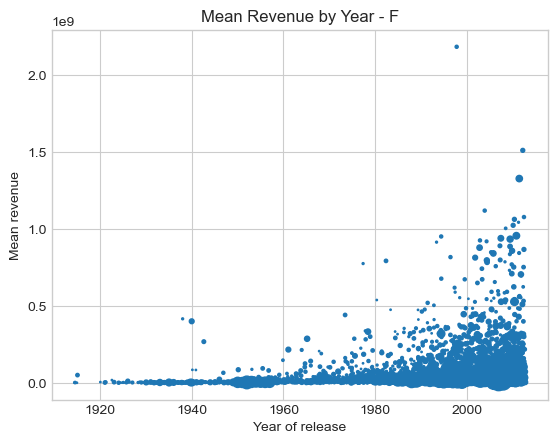

In [944]:
revenue_year = characters_movie_F.groupby("Movie_release_date_x")['Movie_box_office_revenue'].agg(['mean','size']).reset_index()
revenue_year.plot(kind = 'scatter', x = 'Movie_release_date_x', y = 'mean',s = 'size')
plt.title('Mean Revenue by Year - F')
plt.ylabel('Mean revenue')
plt.xlabel('Year of release')
plt.show()

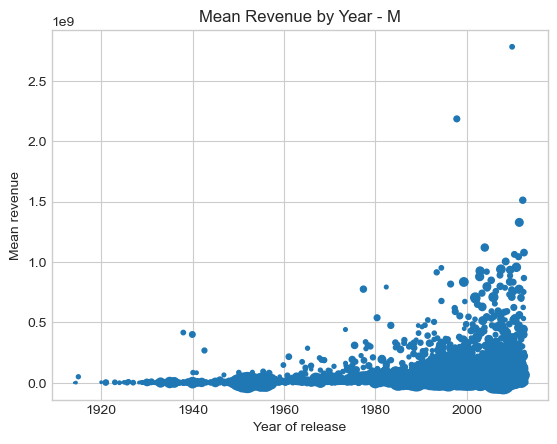

In [945]:
revenue_year = characters_movie_M.groupby("Movie_release_date_x")['Movie_box_office_revenue'].agg(['mean','size']).reset_index()
revenue_year.plot(kind = 'scatter', x = 'Movie_release_date_x', y = 'mean',s = 'size')
plt.title('Mean Revenue by Year - M')
plt.ylabel('Mean revenue')
plt.xlabel('Year of release')
plt.show()

From what we can see on this first visualization, it seems like movies with male characters en up having a bigger mean revenue in box office revenue compared to movies with female characters.

We did not manage to find any data on the actor's salaries for each movies. This would've been a way to visualize discrimination between genders and we will continue to look in case we end up finding some data.

---

# 3. Evolution of women representation <a id="Evolution"> </a>


##  A. Are women present? <a id="Presence"> </a>

### Feminine vs. masculine pronouns occurence

In [946]:
def indicator_variable(dic,x,s):
    '''
    Returns indicator variable which equals to 1 if the corresponding headline uses 
    the corresponding type of pronoun and 0 otherwise.
    :param dic: dictionary
    :param x: string
    :param s: string
    :return: indicator variable
    '''
    return int(bool(set(dic[s]) & set(x.lower().split(" "))))

In [947]:
# Keep only 1 example per movie. Here we will keep the first one, but it doesn't matter as we work on the summaries and not on the actors themselves

plot_summaries = plot_summaries.drop_duplicates(subset='Freebase_movie_ID', keep="first")

In [948]:
feature_wordsets = dict([
    # https://en.wikipedia.org/wiki/English_personal_pronouns
    ('fem_pronoun', ['she','her','hers','herself', 
                               "she'll", "she's", 'shes']),
    ('masc_pronoun', ['he','him','his','himself',
                               "he'd", "he's", 'hes'])
])

plot_summaries["fem_pronoun"] = plot_summaries["Plot_Summary"].apply(lambda x : indicator_variable(feature_wordsets,x,'fem_pronoun'))
plot_summaries["masc_pronoun"] = plot_summaries["Plot_Summary"].apply(lambda x : indicator_variable(feature_wordsets,x,'masc_pronoun'))


In [949]:
length_summaries = len(plot_summaries)
print('The number of summaries with feminine pronouns occurence:', sum(plot_summaries["fem_pronoun"]))
print('The percentage of summaries with feminine pronouns occurence:', 100*(sum(plot_summaries["fem_pronoun"]))/ length_summaries, "%")
print('The number of summaries with masculine pronouns occurence:', sum(plot_summaries["masc_pronoun"]))
print('The percentage of summaries with masculine pronouns occurence:', 100*(sum(plot_summaries["masc_pronoun"]))/ length_summaries, "%")

The number of summaries with feminine pronouns occurence: 10492
The percentage of summaries with feminine pronouns occurence: 70.7866684657941 %
The number of summaries with masculine pronouns occurence: 13337
The percentage of summaries with masculine pronouns occurence: 89.9811091620564 %


We observe that there is more than 29% difference between the occurence of feminine and masculine pronouns in the given summaries.

We can check if the pronouns occurence changes through time.

In [950]:
plot_summaries.head(10)

Plot_Summary  \
Wikipedia_movie_ID                                                      
31186339            The nation of Panem consists of a wealthy Capi...   
20663735            Poovalli Induchoodan  is sentenced for six yea...   
595909              Seventh-day Adventist Church pastor Michael Ch...   
5272176             The president is on his way to give a speech. ...   
1952976             {{plot}} The film opens in 1974, as a young gi...   
24225279            The story begins with Hannah, a young Jewish t...   
15401493            Lola  attempts to gain her father's trust fund...   
1335380             The film is based on the events that happened ...   
1480747             {{plot}} Following the sudden death of Kid's f...   
4018288             Debbie's favorite band is Dream Street, and he...   

                   Freebase_movie_ID Movie_release_date       Character_name  \
Wikipedia_movie_ID                                                             
31186339                  /m/0gkz15s         2012-03-12       Gale Hawthorne   
20663735                  /m/051zjwb               2000     Nandagopal Marar   
595909                     /m/02tqm5         1988-11-03  Michael Chamberlain   
5272176                    /m/0dbxtv               2006        Kate Crawford   
1952976                    /m/068jvg         2005-06-27               Dahlia   
24225279                  /m/07kbs3s               1989        Miss Lombardo   
15401493                  /m/03m7584         2008-01-24                Marco   
1335380                    /m/04tng0         1960-12-15       Ari Ben Canaan   
1480747                    /m/054vql         1991-10-23     Sheila Landreaux   
4018288                    /m/0bcs3m               2002         Richard Limp   

                   Actor_date_of_birth Actor_gender  Actor_height  \
Wikipedia_movie_ID                                                  
31186339                    1990-01-13            M         1.910   
20663735                    1951-09-07            M         1.780   
595909                      1947-09-14            M         1.822   
5272176                     1972-08-10            F         1.765   
1952976                     1970-12-12            F         1.690   
24225279                    1954-10-02            F         1.702   
15401493                    1973-10-10            M         1.800   
1335380                     1925-01-26            M         1.770   
1480747                     1955-07-25            F         1.753   
4018288                     1932-06-28            M         1.600   

                   Actor_ethnicity         Actor_name  \
Wikipedia_movie_ID                                      
31186339                /m/0bbz66j     Liam Hemsworth   
20663735                 /m/04mvp8          Mammootty   
595909                   /m/02jvpv          Sam Neill   
5272176                  /m/07bch9       Angie Harmon   
1952976                   /m/041rx  Jennifer Connelly   
24225279                  /m/0xnvg    Lorraine Bracco   
15401493                 /m/01g7zj        Mario López   
1335380                 /m/027n1m6        Paul Newman   
1480747                  /m/05cc9h    Iman Abdulmajid   
4018288                   /m/0cn68         Pat Morita   

                    Actor_age_at_movie_release  \
Wikipedia_movie_ID                               
31186339                                  22.0   
20663735                                  48.0   
595909                                    41.0   
5272176                                   33.0   
1952976                                   34.0   
24225279                                  34.0   
15401493                                  34.0   
1335380                                   35.0   
1480747                                   36.0   
4018288                                   69.0   

                   Freebase_character_actor_map_ID Freebase_character_ID  \
Wikipedia_movie_ID          

In [951]:

summaries_with_date = plot_summaries.dropna()
summaries_with_date["Movie_release_date"] = pd.to_datetime(summaries_with_date["Movie_release_date"],errors='coerce')
summaries_with_date = summaries_with_date.sort_values(by="Movie_release_date")

In [952]:
#split dataset into three parts: before 2007, between 2007 and 2016, and after 2016

summaries_before2007 = summaries_with_date[summaries_with_date["Movie_release_date"] < "2007-01-01"]
summaries_2007 = summaries_with_date[(summaries_with_date["Movie_release_date"] >= "2007-01-01") & (summaries_with_date["Movie_release_date"] < "2016-01-01") ]
summaries_2016 = summaries_with_date[summaries_with_date["Movie_release_date"] >= "2016-01-01"]

print('The dataset with movies from after 2016 is empty, as its length is ', len(summaries_2016))

print('The number of summaries before 2007 with feminine pronouns occurence:', sum(summaries_before2007["fem_pronoun"]))
print('The percentage of summaries before 2007 with feminine pronouns occurence:', 100*(sum(summaries_before2007["fem_pronoun"]))/ len(summaries_before2007), "%")

print('The number of summaries before 2007 with masculine pronouns occurence:', sum(summaries_before2007["masc_pronoun"]))
print('The percentage of summaries before 2007 with masculine pronouns occurence:', 100*(sum(summaries_before2007["masc_pronoun"]))/ len(summaries_before2007), "%")

print('The number of summaries after 2007 with feminine pronouns occurence:', sum(summaries_2007["fem_pronoun"]))
print('The percentage of summaries after 2007 with feminine pronouns occurence:', 100*(sum(summaries_2007["fem_pronoun"]))/ len(summaries_2007), "%")

print('The number of summaries after 2007 with masculine pronouns occurence:', sum(summaries_2007["masc_pronoun"]))
print('The percentage of summaries after 2007 with masculine pronouns occurence:', 100*(sum(summaries_2007["masc_pronoun"]))/ len(summaries_2007), "%")


The dataset with movies from after 2016 is empty, as its length is  0
The number of summaries before 2007 with feminine pronouns occurence: 8028
The percentage of summaries before 2007 with feminine pronouns occurence: 70.42105263157895 %
The number of summaries before 2007 with masculine pronouns occurence: 10323
The percentage of summaries before 2007 with masculine pronouns occurence: 90.55263157894737 %
The number of summaries after 2007 with feminine pronouns occurence: 2464
The percentage of summaries after 2007 with feminine pronouns occurence: 72.00467562828756 %
The number of summaries after 2007 with masculine pronouns occurence: 3014
The percentage of summaries after 2007 with masculine pronouns occurence: 88.0771478667446 %


On the period before and after 2007, we see a slight increase in feminine pronouns occurence and a slight decrease in masculine pronouns occurence (2% each time), always with masculine pronouns mainly used in movies summaries. The subgroups tendencies are aligned with the entire group (it is not a Simpson paradox).

These results can not be largely interpreted as the subgroup "before 2007" is five times larger than the "after 2007" subgroup. Results can be biased due to the different number of samples.


### Feminine vs. masculine pronouns count

In [953]:
#create a function that counts the occurence of a word in a string
def count_word(word, string):
    return string.count(word)

In [954]:
#count the number of times each class of pronoun is mentioned in the plot summary
plot_summaries['fem_occurence'] = 0
plot_summaries['masc_occurence'] = 0

for y in feature_wordsets['fem_pronoun']:
    plot_summaries['fem_occurence'] = plot_summaries['fem_occurence'] + plot_summaries.apply(lambda x: count_word(y, x['Plot_Summary']), axis=1)

for y in feature_wordsets['masc_pronoun']:
    plot_summaries['masc_occurence'] = plot_summaries['masc_occurence'] + plot_summaries.apply(lambda x: count_word(y, x['Plot_Summary']), axis=1)

plot_summaries.head(10)

Plot_Summary  \
Wikipedia_movie_ID                                                      
31186339            The nation of Panem consists of a wealthy Capi...   
20663735            Poovalli Induchoodan  is sentenced for six yea...   
595909              Seventh-day Adventist Church pastor Michael Ch...   
5272176             The president is on his way to give a speech. ...   
1952976             {{plot}} The film opens in 1974, as a young gi...   
24225279            The story begins with Hannah, a young Jewish t...   
15401493            Lola  attempts to gain her father's trust fund...   
1335380             The film is based on the events that happened ...   
1480747             {{plot}} Following the sudden death of Kid's f...   
4018288             Debbie's favorite band is Dream Street, and he...   

                   Freebase_movie_ID Movie_release_date       Character_name  \
Wikipedia_movie_ID                                                             
31186339                  /m/0gkz15s         2012-03-12       Gale Hawthorne   
20663735                  /m/051zjwb               2000     Nandagopal Marar   
595909                     /m/02tqm5         1988-11-03  Michael Chamberlain   
5272176                    /m/0dbxtv               2006        Kate Crawford   
1952976                    /m/068jvg         2005-06-27               Dahlia   
24225279                  /m/07kbs3s               1989        Miss Lombardo   
15401493                  /m/03m7584         2008-01-24                Marco   
1335380                    /m/04tng0         1960-12-15       Ari Ben Canaan   
1480747                    /m/054vql         1991-10-23     Sheila Landreaux   
4018288                    /m/0bcs3m               2002         Richard Limp   

                   Actor_date_of_birth Actor_gender  Actor_height  \
Wikipedia_movie_ID                                                  
31186339                    1990-01-13            M         1.910   
20663735                    1951-09-07            M         1.780   
595909                      1947-09-14            M         1.822   
5272176                     1972-08-10            F         1.765   
1952976                     1970-12-12            F         1.690   
24225279                    1954-10-02            F         1.702   
15401493                    1973-10-10            M         1.800   
1335380                     1925-01-26            M         1.770   
1480747                     1955-07-25            F         1.753   
4018288                     1932-06-28            M         1.600   

                   Actor_ethnicity         Actor_name  \
Wikipedia_movie_ID                                      
31186339                /m/0bbz66j     Liam Hemsworth   
20663735                 /m/04mvp8          Mammootty   
595909                   /m/02jvpv          Sam Neill   
5272176                  /m/07bch9       Angie Harmon   
1952976                   /m/041rx  Jennifer Connelly   
24225279                  /m/0xnvg    Lorraine Bracco   
15401493                 /m/01g7zj        Mario López   
1335380                 /m/027n1m6        Paul Newman   
1480747                  /m/05cc9h    Iman Abdulmajid   
4018288                   /m/0cn68         Pat Morita   

                    Actor_age_at_movie_release  \
Wikipedia_movie_ID                               
31186339                                  22.0   
20663735                                  48.0   
595909                                    41.0   
5272176                                   33.0   
1952976                                   34.0   
24225279                                  34.0   
15401493                                  34.0   
1335380                                   35.0   
1480747                                   36.0   
4018288                                   69.0   

                   Freebase_character_actor_map_ID Freebase_character_ID  \
Wikipedia_movie_ID          

In [955]:
print('The mean of feminine pronouns occurence in summaries:', plot_summaries['fem_occurence'].mean())
print('The mean of masculine pronouns occurence in summaries:', plot_summaries['masc_occurence'].mean())
print('the mean difference between feminine and masculine pronouns occurence in summaries:', plot_summaries['fem_occurence'].mean() - plot_summaries['masc_occurence'].mean())

The mean of feminine pronouns occurence in summaries: 14.332951018755903
The mean of masculine pronouns occurence in summaries: 67.19174200512751
the mean difference between feminine and masculine pronouns occurence in summaries: -52.8587909863716


We clearly see that masculine pronouns are almost 5 times more used.

The next step would be to compare the mean number of fem/masc pronouns in function of movie genres, and compare this result to the length of summaries too (maybe action movies have shorter summaries, and they are also more representative of the men population).


In [956]:
# add the movie_genres column from movie_metadata dataset to plot_summaries dataset
plot_summaries = plot_summaries.merge(movie_metadata[['Freebase_movie_ID','Movie_genres']], on='Freebase_movie_ID', how='left')
plot_summaries

Plot_Summary Freebase_movie_ID  \
0      The nation of Panem consists of a wealthy Capi...        /m/0gkz15s   
1      Poovalli Induchoodan  is sentenced for six yea...        /m/051zjwb   
2      Seventh-day Adventist Church pastor Michael Ch...         /m/02tqm5   
3      The president is on his way to give a speech. ...         /m/0dbxtv   
4      {{plot}} The film opens in 1974, as a young gi...         /m/068jvg   
...                                                  ...               ...   
14817  Dr. Sullivan Travis   is a wealthy Dallas gyne...         /m/0323y3   
14818  The story develops around the evolution of Tit...        /m/0279p_0   
14819  In Northern Norway during the 1860s, a little ...         /m/0cty8f   
14820  While drinking alone one night and reminiscing...        /m/0b76dxj   
14821  A high school prom in Georgia is unexpectedly ...        /m/04ydw1v   

      Movie_release_date       Character_name Actor_date_of_birth  \
0             2012-03-12       Gale Hawthorne          1990-01-13   
1                   2000     Nandagopal Marar          1951-09-07   
2             1988-11-03  Michael Chamberlain          1947-09-14   
3                   2006        Kate Crawford          1972-08-10   
4             2005-06-27               Dahlia          1970-12-12   
...                  ...                  ...                 ...   
14817         2000-09-12                Dr. T          1949-08-31   
14818               2002            Rohit Roy          1950-06-16   
14819         2002-03-08        Leo Zhukovsky          1964-02-16   
14820               1989                Xenos          1919-02-18   
14821         2008-10-13               Jensen          1990-08-10   

      Actor_gender  Actor_height Actor_ethnicity             Actor_name  \
0                M         1.910      /m/0bbz66j         Liam Hemsworth   
1                M         1.780       /m/04mvp8              Mammootty   
2                M         1.822       /m/02jvpv              Sam Neill   
3                F         1.765       /m/07bch9           Angie Harmon   
4                F         1.690        /m/041rx      Jennifer Connelly   
...            ...           ...             ...                    ...   
14817            M         1.800       /m/033tf_           Richard Gere   
14818            M         1.830       /m/0bpjh3     Mithun Chakraborty   
14819            M         1.830       /m/02w7gg  Christopher Eccleston   
14820            M         1.930       /m/0ffjvd           Jack Palance   
14821            M         1.780       /m/02ctzb             Lucas Till   

       Actor_age_at_movie_release Freebase_character_actor_map_ID  \
0                            22.0                      /m/0gw7kv7   
1                            48.0                      /m/059t6pv   
2                            41.0                      /m/02tbjj2   
3                            33.0                      /m/02vcql2   
4                            34.0                       /m/0jwzp0   
...                           ...                             ...   
14817                        51.0                      /m/02vch2k   
14818                        51.0                      /m/03js489   
14819                        38.0                       /m/0jzpw0   
14820                        69.0                      /m/0gm35v0   
14821                        18.0                      /m/0cg5yh3   

      Freebase_character_ID Freebase_actor_ID  fem_pronoun  masc_pronoun  \
0                /m/0ds96_p        /m/04yd0fh            1             1   
1                /m/0h27qg5         /m/02hkv5            1             1   
2                /m/0h2qv0j         /m/01ckhj            1             1   
3                /m/0h0x8g4         /m/03sysz            1             1   
4                /m/0dds1wb          /m/0fgg4            1             1   
...                     ...               ...          ...           ...   
14817           

In [957]:
# add a genre to the movie in function of the highest pronoun occurence

def genre_pronoun(row):
    if row['fem_occurence'] > row['masc_occurence']:
        return 'F'
    elif row['fem_occurence'] < row['masc_occurence']:
        return 'M'
    else:
        return 'N'

plot_summaries['genre_pronoun'] = plot_summaries.apply(lambda row: genre_pronoun(row), axis=1)
plot_summaries

Plot_Summary Freebase_movie_ID  \
0      The nation of Panem consists of a wealthy Capi...        /m/0gkz15s   
1      Poovalli Induchoodan  is sentenced for six yea...        /m/051zjwb   
2      Seventh-day Adventist Church pastor Michael Ch...         /m/02tqm5   
3      The president is on his way to give a speech. ...         /m/0dbxtv   
4      {{plot}} The film opens in 1974, as a young gi...         /m/068jvg   
...                                                  ...               ...   
14817  Dr. Sullivan Travis   is a wealthy Dallas gyne...         /m/0323y3   
14818  The story develops around the evolution of Tit...        /m/0279p_0   
14819  In Northern Norway during the 1860s, a little ...         /m/0cty8f   
14820  While drinking alone one night and reminiscing...        /m/0b76dxj   
14821  A high school prom in Georgia is unexpectedly ...        /m/04ydw1v   

      Movie_release_date       Character_name Actor_date_of_birth  \
0             2012-03-12       Gale Hawthorne          1990-01-13   
1                   2000     Nandagopal Marar          1951-09-07   
2             1988-11-03  Michael Chamberlain          1947-09-14   
3                   2006        Kate Crawford          1972-08-10   
4             2005-06-27               Dahlia          1970-12-12   
...                  ...                  ...                 ...   
14817         2000-09-12                Dr. T          1949-08-31   
14818               2002            Rohit Roy          1950-06-16   
14819         2002-03-08        Leo Zhukovsky          1964-02-16   
14820               1989                Xenos          1919-02-18   
14821         2008-10-13               Jensen          1990-08-10   

      Actor_gender  Actor_height Actor_ethnicity             Actor_name  \
0                M         1.910      /m/0bbz66j         Liam Hemsworth   
1                M         1.780       /m/04mvp8              Mammootty   
2                M         1.822       /m/02jvpv              Sam Neill   
3                F         1.765       /m/07bch9           Angie Harmon   
4                F         1.690        /m/041rx      Jennifer Connelly   
...            ...           ...             ...                    ...   
14817            M         1.800       /m/033tf_           Richard Gere   
14818            M         1.830       /m/0bpjh3     Mithun Chakraborty   
14819            M         1.830       /m/02w7gg  Christopher Eccleston   
14820            M         1.930       /m/0ffjvd           Jack Palance   
14821            M         1.780       /m/02ctzb             Lucas Till   

       Actor_age_at_movie_release Freebase_character_actor_map_ID  \
0                            22.0                      /m/0gw7kv7   
1                            48.0                      /m/059t6pv   
2                            41.0                      /m/02tbjj2   
3                            33.0                      /m/02vcql2   
4                            34.0                       /m/0jwzp0   
...                           ...                             ...   
14817                        51.0                      /m/02vch2k   
14818                        51.0                      /m/03js489   
14819                        38.0                       /m/0jzpw0   
14820                        69.0                      /m/0gm35v0   
14821                        18.0                      /m/0cg5yh3   

      Freebase_character_ID Freebase_actor_ID  fem_pronoun  masc_pronoun  \
0                /m/0ds96_p        /m/04yd0fh            1             1   
1                /m/0h27qg5         /m/02hkv5            1             1   
2                /m/0h2qv0j         /m/01ckhj            1             1   
3                /m/0h0x8g4         /m/03sysz            1             1   
4                /m/0dds1wb          /m/0fgg4            1             1   
...                     ...               ...          ...           ...   
14817           

In [958]:
plot_summaries

Plot_Summary Freebase_movie_ID  \
0      The nation of Panem consists of a wealthy Capi...        /m/0gkz15s   
1      Poovalli Induchoodan  is sentenced for six yea...        /m/051zjwb   
2      Seventh-day Adventist Church pastor Michael Ch...         /m/02tqm5   
3      The president is on his way to give a speech. ...         /m/0dbxtv   
4      {{plot}} The film opens in 1974, as a young gi...         /m/068jvg   
...                                                  ...               ...   
14817  Dr. Sullivan Travis   is a wealthy Dallas gyne...         /m/0323y3   
14818  The story develops around the evolution of Tit...        /m/0279p_0   
14819  In Northern Norway during the 1860s, a little ...         /m/0cty8f   
14820  While drinking alone one night and reminiscing...        /m/0b76dxj   
14821  A high school prom in Georgia is unexpectedly ...        /m/04ydw1v   

      Movie_release_date       Character_name Actor_date_of_birth  \
0             2012-03-12       Gale Hawthorne          1990-01-13   
1                   2000     Nandagopal Marar          1951-09-07   
2             1988-11-03  Michael Chamberlain          1947-09-14   
3                   2006        Kate Crawford          1972-08-10   
4             2005-06-27               Dahlia          1970-12-12   
...                  ...                  ...                 ...   
14817         2000-09-12                Dr. T          1949-08-31   
14818               2002            Rohit Roy          1950-06-16   
14819         2002-03-08        Leo Zhukovsky          1964-02-16   
14820               1989                Xenos          1919-02-18   
14821         2008-10-13               Jensen          1990-08-10   

      Actor_gender  Actor_height Actor_ethnicity             Actor_name  \
0                M         1.910      /m/0bbz66j         Liam Hemsworth   
1                M         1.780       /m/04mvp8              Mammootty   
2                M         1.822       /m/02jvpv              Sam Neill   
3                F         1.765       /m/07bch9           Angie Harmon   
4                F         1.690        /m/041rx      Jennifer Connelly   
...            ...           ...             ...                    ...   
14817            M         1.800       /m/033tf_           Richard Gere   
14818            M         1.830       /m/0bpjh3     Mithun Chakraborty   
14819            M         1.830       /m/02w7gg  Christopher Eccleston   
14820            M         1.930       /m/0ffjvd           Jack Palance   
14821            M         1.780       /m/02ctzb             Lucas Till   

       Actor_age_at_movie_release Freebase_character_actor_map_ID  \
0                            22.0                      /m/0gw7kv7   
1                            48.0                      /m/059t6pv   
2                            41.0                      /m/02tbjj2   
3                            33.0                      /m/02vcql2   
4                            34.0                       /m/0jwzp0   
...                           ...                             ...   
14817                        51.0                      /m/02vch2k   
14818                        51.0                      /m/03js489   
14819                        38.0                       /m/0jzpw0   
14820                        69.0                      /m/0gm35v0   
14821                        18.0                      /m/0cg5yh3   

      Freebase_character_ID Freebase_actor_ID  fem_pronoun  masc_pronoun  \
0                /m/0ds96_p        /m/04yd0fh            1             1   
1                /m/0h27qg5         /m/02hkv5            1             1   
2                /m/0h2qv0j         /m/01ckhj            1             1   
3                /m/0h0x8g4         /m/03sysz            1             1   
4                /m/0dds1wb          /m/0fgg4            1             1   
...                     ...               ...          ...           ...   
14817           

In [959]:
plot_summaries = plot_summaries.drop(plot_summaries[plot_summaries['genre_pronoun'] == 'N'].index, inplace = True)
plot_summaries.head()

AttributeError: 'NoneType' object has no attribute 'head'

In [ ]:
# split the movie_genres list into a list of genres with pd.explode

In [ ]:
# count the mean feminine and masculine pronouns occurence for each movie_genres
#fm = plot_summaries.groupby('Movie_genres')['fem_occurence'].agg(['mean'])
#mm = plot_summaries.groupby('Movie_genres')['masc_occurence'].mean()

# function pd.explode() is used to split the values in the column 'Genre' into multiple rows

These results can be compared to the character_occurence (= gender of main character of each movie) also in function of movie genres for example.

### Detecting the main character in each movie 

To detect the main character in each movie, we assume the main character is the character from character_data that appears the most in the summary.

In [ ]:

character_metadata=character_metadata.drop_duplicates()
print('There are normally', len(character_metadata),'characters')

There are normally 450127 characters


In [ ]:
character_dropna_name = character_metadata.dropna(subset=['Character_name'])
print('Percentage of missing entries in the name of the characters dataset:\n', 100*character_metadata[['Character_name']].isna().sum() / n_char)
character_dropna_name

Percentage of missing entries in the name of the characters dataset:
 Character_name    57.148373
dtype: float64


Freebase_movie_ID Movie_release_date  \
Wikipedia_movie_ID                                        
975900                     /m/03vyhn         2001-08-24   
975900                     /m/03vyhn         2001-08-24   
975900                     /m/03vyhn         2001-08-24   
975900                     /m/03vyhn         2001-08-24   
975900                     /m/03vyhn         2001-08-24   
...                              ...                ...   
913762                     /m/03pcrp         1992-05-21   
913762                     /m/03pcrp         1992-05-21   
913762                     /m/03pcrp         1992-05-21   
913762                     /m/03pcrp         1992-05-21   
913762                     /m/03pcrp         1992-05-21   

                                Character_name Actor_date_of_birth  \
Wikipedia_movie_ID                                                   
975900                                Akooshay          1958-08-26   
975900              Lieutenant Melanie Ballard          1974-08-15   
975900                     Desolation Williams          1969-06-15   
975900                      Sgt Jericho Butler          1967-09-12   
975900                         Bashira Kincaid          1977-09-25   
...                                        ...                 ...   
913762                      UN Spacy Commander                1954   
913762                             Silvie Gena                1958   
913762                                 Exegran                 NaN   
913762                                  Elensh             1970-05   
913762                                  Hibiki          1965-04-12   

                   Actor_gender  Actor_height Actor_ethnicity  \
Wikipedia_movie_ID                                              
975900                        F         1.620             NaN   
975900                        F         1.780      /m/044038p   
975900                        M         1.727         /m/0x67   
975900                        M         1.750             NaN   
975900                        F         1.650             NaN   
...                         ...           ...             ...   
913762                        M           NaN             NaN   
913762                        F           NaN             NaN   
913762                        M           NaN             NaN   
913762                        F           NaN             NaN   
913762                        M           NaN             NaN   

                            Actor_name  Actor_age_at_movie_release  \
Wikipedia_movie_ID                                                   
975900                  Wanda De Jesus                        42.0   
975900              Natasha Henstridge                        27.0   
975900                        Ice Cube                        32.0   
975900                   Jason Statham                        33.0   
975900                     Clea DuVall                        23.0   
...                                ...                         ...   
913762                   Sonny Byrkett                        38.0   
913762                   Susan Byrkett                        34.0   
913762                  Hal Cleaveland                         NaN   
913762              Dorothy Elias-Fahn                         NaN   
913762                   Jonathan Fahn                        27.0   

                   Freebase_character_actor_map_ID Freebase_character_ID  \
Wikipedia_movie_ID                                                         
975900                                  /m/0bgchxw            /m/0bgcj3x   
975900                                   /m/0jys3m            /m/0bgchn4   
975900                                   /m/0jys3g            /m/0bgchn_   
975900                                  /m/02vchl6            /m/0bgchnq   
975900                                  /m/02vbb3r            /m/0bgchp9   
...                                            ... 

In [ ]:

#count the number of times each character is mentioned in the plot summary

plot_summaries['Character_occurence'] = plot_summaries.apply(lambda x: count_word(x['Character_name'], x['Plot_Summary']), axis=1)

plot_summaries.head(5)

In [ ]:
#create dataframe with the highest character occurence for each Freebase movie ID and the corresponding character name and gender

character_occurence = plot_summaries.groupby('Freebase_movie_ID')['Character_occurence'].max().reset_index()
character_occurence = character_occurence.merge(plot_summaries[['Freebase_movie_ID', 'Character_name', 'Character_occurence']], on=['Freebase_movie_ID', 'Character_occurence'], how='left')
character_occurence = character_occurence.drop_duplicates(subset='Freebase_movie_ID', keep='first')
character_occurence = character_occurence.drop('Character_occurence', axis=1)
character_occurence

#add character name and gender to character_occurence
character_occurence = character_occurence.merge(character_metadata[['Freebase_movie_ID', 'Character_name', 'Actor_gender']], on=['Freebase_movie_ID', 'Character_name'], how='left')

character_occurence.head(10)


Freebase_movie_ID              Character_name Actor_gender
0         /m/011wtv               John Anderton            M
1         /m/011x_4                Phil Connors            M
2         /m/011xg5                       David            M
3         /m/011xrr           Lord John Whorfin            M
4         /m/011ycb              Sandra Goodwin            F
5         /m/011yd2  Sy Liebergot - EECOM White            M
6         /m/011ydl                         Fly            F
7         /m/011yfd              Beatrice Russo            F
8         /m/011yg9             Elinor Dashwood            F
9         /m/011yhm              Carl Showalter            M

Freebase_movie_ID    5722
Character_name       5722
Actor_gender         5722
dtype: int64


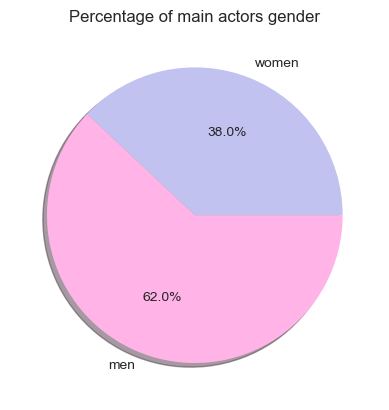

In [ ]:
x=character_occurence[character_occurence['Actor_gender'] == 'F'].count()
print(x)
y=character_occurence[character_occurence['Actor_gender'] == 'M'].count()
#plot x and y in a pie chart
plt.pie([x[0] , y[0]],labels=['women','men'],colors = ['#c2c2f0','#ffb3e6'],autopct='%1.1f%%',shadow=True)
plt.title('Percentage of main actors gender')
plt.show()

could be interesting to see the evolution through time of number of main characters per gender for 10-years periods

##  B. What are women associated with? How do we talk about these women? <a name="Association"> </a>

### i. Associate words/champ lexical in summaries in function of movie_gender [F; M] which is based on the gender of the main actor


In [ ]:
# merge character_occurence with plot_summaries on Freebase_movie_ID

# create a column movie_gender in plot_summaries in function of gender of main character in character_occurence dataset

# do the NLP algorithm to split words in F, M and both gender categories





#### In general

#### Group by year

#### Group by movie genres

#### Visualization: scatter plot, words viz

### ii. Associate tropes/stereotypes to women and men

#### From tropes_cluster, classify not obvious tropes into feminine or masculine 


#### Identify ideas that come out of these tropes from both categories (topic detection)

#### Identify if there are equivalent tropes between men and women

## C. What kind of roles or jobs done by women are the most appreciated? In which context do people like to see women? <a name="Roles"> </a>

### i. From IMDB ratings, check number of women between high and low score movies

First, we need to associate the ratings from IMDb with the movies we have from movie_metadata.

In [ ]:
# merge movie_metadata and character_metadata on Freebase_movie_ID and Movie_release_date to have a combination of actors, genders and movie titles
actor_title = movie_metadata.merge(character_metadata[['Freebase_movie_ID', 'Character_name', 'Actor_gender']], on=['Freebase_movie_ID']).drop(['Movie_box_office_revenue', 'Movie_runtime', 'Movie_languages', 'Movie_countries'], axis=1)

# drop rows where character_name = Nan
actor_title = actor_title.dropna(subset=['Character_name'])

In [ ]:
print('There are %2d unique movies in the actor_title dataset.' %(actor_title[['Movie_name']].nunique()))
print('There are %2d unique movies in the IMDb dataset.' %(IMDb_ratings[['Movie_name']].nunique()))


There are 30614 unique movies in the actor_title dataset.
There are 58429 unique movies in the IMDb dataset.


In [ ]:
# create a dataset with the IMDB_rating and the number of votes and the character name and gender for each movie in common of IMDb_ratings and actor_movie
movie_ratings = IMDb_ratings.merge(actor_title, on='Movie_name', how='left')

# drop rows where there is no freebase_movie_id
movie_ratings = movie_ratings.dropna(subset='Freebase_movie_ID').drop(['Movie_genres_x'], axis=1).rename(columns={'Movie_genres_y': 'Movie_genres'})

In [ ]:
print('There are %2d unique movies in the combination of given and IMDb data, the movie_ratings dataset.' %(movie_ratings[['Movie_name']].nunique()))


There are 15527 unique movies in the combination of given and IMDb data, the movie_ratings dataset.


Our further analysis on gender gap through ratings will thus be based on 15527 movies.

In [ ]:
movie_ratings

IMDb_rating  IMDb_votes titleType          Movie_name  \
3               4.3          23     movie  Robbery Under Arms   
4               4.3          23     movie  Robbery Under Arms   
5               4.3          23     movie  Robbery Under Arms   
6               4.3          23     movie  Robbery Under Arms   
7               4.3          23     movie  Robbery Under Arms   
...             ...         ...       ...                 ...   
188482          3.0       18401     movie              Breach   
188483          3.0       18401     movie              Breach   
188501          5.3        1663     movie              Police   
188502          5.3        1663     movie              Police   
188503          5.3        1663     movie              Police   

       Movie_release_year Freebase_movie_ID Movie_release_date  \
3                    1907        /m/0bhcws6         1985-03-28   
4                    1907        /m/04p7yxx         1907-11-02   
5                    1907        /m/04p7yxx         1907-11-02   
6                    1907        /m/04p7yxx         1907-11-02   
7                    1907        /m/04p7yxx         1907-11-02   
...                   ...               ...                ...   
188482               2020        /m/0270dq8         2007-02-16   
188483               2020        /m/0270dq8         2007-02-16   
188501               2020         /m/0fcxy9         2005-01-01   
188502               2020         /m/0fcxy9         2005-01-01   
188503               2020         /m/0fcxy9         2005-01-01   

                                             Movie_genres  \
3            [History, Western, Action, Drama, Adventure]   
4                                    [Silent film, Drama]   
5                                    [Silent film, Drama]   
6                                    [Silent film, Drama]   
7                                    [Silent film, Drama]   
...                                                   ...   
188482  [Crime Fiction, Thriller, Docudrama, Drama, Cr...   
188483  [Crime Fiction, Thriller, Docudrama, Drama, Cr...   
188501                          [Crime Fiction, Thriller]   
188502                          [Crime Fiction, Thriller]   
188503                          [Crime Fiction, Thriller]   

             Character_name Actor_gender  
3           Capt. Starlight            M  
4                   Trooper            M  
5                  Warrigal            M  
6                    Warder            M  
7       Inspector of Police            M  
...                     ...          ...  
188482         John O'Neill            M  
188483            Jim Olsen            M  
188501        Shekhar Varma            M  
188502               Kirthi            F  
188503                Iqbal            M  

[144580 rows x 10 columns]

> The movie release years from IMDb don't correspond to the movie release date from the given dataset. Does that mean that those are not the same movies, even if they have the same name? We decide to ignore this anomaly for the rest of the analysis by dropping the movie release year from IMDb.

In [ ]:
# drop IMDb release year for movies as they don't correspond to given data sets movies release years
movie_ratings = movie_ratings.drop(['Movie_release_year'], axis=1)

In [ ]:
# check whether there are only movies in the movie_ratings df - not very useful as only freebase_movie_ID != NaN selected
movie_ratings['titleType'].unique()

array(['movie'], dtype=object)

In [ ]:
# count the number of masculie vs. feminine character for each movie and put it in column F and M
fm = movie_ratings.groupby(['Movie_name', 'Actor_gender']).size().unstack(fill_value=0)

# keep only 1 line per movie
movie_ratings_FM = movie_ratings.merge(fm, on='Movie_name', how='left').drop_duplicates(subset='Movie_name', keep="first")

movie_ratings_FM

IMDb_rating  IMDb_votes titleType                      Movie_name  \
0               4.3          23     movie              Robbery Under Arms   
7               5.2          66     movie  The Fairylogue and Radio-Plays   
9               4.7          38     movie                          Hamlet   
95              5.1         537     movie                       Cleopatra   
133             5.8         597     movie    From the Manger to the Cross   
...             ...         ...       ...                             ...   
144462          7.4        2273     movie                          Digger   
144470          7.3       14953     movie                            Bala   
144480          3.0         905     movie                           Jumbo   
144501          5.8        7600     movie              Pati Patni Aur Woh   
144551          3.9        1085     movie                     Crime Story   

       Freebase_movie_ID Movie_release_date  \
0             /m/0bhcws6         1985-03-28   
7              /m/0fgfyy         1908-09-24   
9              /m/0dtx8p         1921-01-10   
95            /m/04lghwf         1912-11-13   
133             /m/0jr0h         1912-10-03   
...                  ...                ...   
144462        /m/043n0k0         1993-01-01   
144470         /m/0f6gc3         2002-01-01   
144480        /m/051z4n5         2008-12-25   
144501        /m/02qnjpw         1978-01-01   
144551         /m/04zfp7         1993-01-01   

                                             Movie_genres   Character_name  \
0            [History, Western, Action, Drama, Adventure]  Capt. Starlight   
7                          [Silent film, Black-and-white]     Dorothy Gale   
9                                                 [Drama]         Gertrude   
95                          [History, Silent film, Drama]        Cleopatra   
133     [Christian film, Silent film, Drama, Indie, Bl...          Lazarus   
...                                                   ...              ...   
144462                    [Romance Film, Childhood Drama]            Billy   
144470  [Action/Adventure, Drama, Tamil cinema, World ...           Aarthi   
144480                           [Family Film, Animation]            Jumbo   
144501  [Romantic comedy, World cinema, Drama, Comedy,...   Sharda Chhadha   
144551  [Crime Fiction, Thriller, World cinema, Action...       Captain Ko   

       Actor_gender      F      M  
0                 M    0.0   14.0  
7                 F    1.0    1.0  
9                 F  153.0  603.0  
95                F   40.0  108.0  
133             NaN    3.0    6.0  
...             ...    ...    ...  
144462            M    0.0    2.0  
144470            F    1.0    2.0  
144480            M    2.0    2.0  
144501            F    3.0    1.0  
144551            M    0.0    1.0  

[15527 rows x 11 columns]

Movies are rated out of 10. Let's determine a threshold mean score: movies with ratings below this threshold score will be considered as low score movies and movies with ratings above this threshold score will be considered as high score movies. 

In [ ]:
threshold = movie_ratings_FM['IMDb_rating'].mean()
#threshold = movie_ratings.groupby('Movie_name')['IMDb_rating'].agg(['mean']).mean()
print('The mean score for IMDb ratings is equal to %2f.' %(threshold)) 


The mean score for IMDb ratings is equal to 6.104045.


We create a low_rating dataframe and a high_score dataframe.

In [ ]:
low_rating = movie_ratings_FM[movie_ratings_FM['IMDb_rating'] < threshold]
high_rating = movie_ratings_FM[movie_ratings_FM['IMDb_rating'] >= threshold]

In [ ]:
print('The length of the low rating data set is of {}.' .format(len(low_rating)))
print('The length of the high rating data set is of {}.' .format(len(high_rating)))

The length of the low rating data set is of 7126.
The length of the high rating data set is of 8401.


Compare mean number of fem_count and masc_count between high and low ratings datasets

In [ ]:
# For low rated movies under threshold
print('Number of women characters in low rated movies: {}.' .format(low_rating.F.mean()))
print('Number of men characters in low rated movies: {}.' .format(low_rating.M.mean()))
print('Percentage of women characters in low rated movies: {}.' .format(low_rating.F.sum()/(low_rating.F.sum()+low_rating.M.sum())))
print('Percentage of men characters in low rated movies: {}.' .format(low_rating.M.sum()/(low_rating.F.sum()+low_rating.M.sum())))

Number of women characters in low rated movies: 2.940365682137834.
Number of men characters in low rated movies: 5.228270042194093.
Percentage of women characters in low rated movies: 0.3599579882573736.
Percentage of men characters in low rated movies: 0.6400420117426264.


In [ ]:
# For high rated movies under threshold
print('Number of women characters in high rated movies: {}.' .format(high_rating.F.mean()))
print('Number of men characters in high rated movies: {}.' .format(high_rating.M.mean()))
print('Percentage of women characters in high rated movies: {}.' .format(high_rating.F.sum()/(high_rating.F.sum()+high_rating.M.sum())))
print('Percentage of men characters in high rated movies: {}.' .format(high_rating.M.sum()/(high_rating.F.sum()+high_rating.M.sum())))

Number of women characters in high rated movies: 3.2962786259541983.
Number of men characters in high rated movies: 6.398139312977099.
Percentage of women characters in high rated movies: 0.3400182091094761.
Percentage of men characters in high rated movies: 0.6599817908905239.


In [ ]:
print('Absolute difference of women characters between high and low rated movies: {}.' .format(high_rating.F.mean()-low_rating.F.mean()))
print('Absolute difference of men characters between high and low rated movies: {}.' .format(high_rating.M.mean()-low_rating.M.mean()))

Absolute difference of women characters between high and low rated movies: 0.3559129438163642.
Absolute difference of men characters between high and low rated movies: 1.169869270783006.


In [ ]:
print('Relative difference of women characters between high and low rated movies: {}.' .format((high_rating.F.mean()-low_rating.F.mean())/(high_rating.F.mean())))
print('Relative difference of men characters between high and low rated movies: {}.' .format((high_rating.M.mean()-low_rating.M.mean())/(high_rating.M.mean())))

Relative difference of women characters between high and low rated movies: 0.10797416851050794.
Relative difference of men characters between high and low rated movies: 0.18284523258351149.


> Comparing the number of woman in low/high rated movies, there is on average 0.36 more women in high rated movies. The relative increase is of 11%.
> Comparing the number of men in low/high rated movies, there is on average 1.17 more men in high rated movies. The relative increase is of 18%.

> The results are not significant. Due to the increase of the number of characters in both movie ratings groups, independently of gender, we could think that a significant feature that impact the ratings is the overall number of characters in a movie, and not the gender of each character. A confounder of these could be the budget of a movie: a higher budget movie will most probably produce a more liked movie (higher ratings on IMDb) and having a higher budget alos allow the production ton hire more actors and develop more characters for the same movie.

In [ ]:
print('Total number of characters in low rated movies: {}.' .format((low_rating.F+low_rating.M).mean()))
print('Total number of characters in high rated movies: {}.' .format((high_rating.F+high_rating.M).mean()))

Total number of characters in low rated movies: 8.168635724331926.
Total number of characters in high rated movies: 9.694417938931299.


In [ ]:
print('Total number of characters in high rated movies: {}.' .format((high_rating.F+high_rating.M).mean()-(low_rating.F+low_rating.M).mean()))

Total number of characters in high rated movies: 1.5257822145993725.


There is indeed on average 1.5 more characters in high ratings movies.

### ii. Compare rating of two movies where main actor is F and M (ponderate by revenues)


##### Attribute a gender to each movie based on gender of main_character

In [ ]:
# we remove unuseful information from the data frame: character name and gender (not main character)
movie_ratings_FM = movie_ratings_FM.drop(['Character_name','Actor_gender'], axis=1)

In [ ]:
# we remove unuseful information from the data frame: character name and gender (not main character)
movie_ratings_FM = movie_ratings_FM.drop(['Character_name','Actor_gender'], axis=1)


# merge character_occurence (main character detetcion) with movie_ratings on Freebase_movie_ID to have column actor_gender = main_char_gender  
movie_gender = movie_ratings_FM.merge(character_occurence[['Freebase_movie_ID','Actor_gender']], on='Freebase_movie_ID', how='left').rename(columns={'Actor_gender': 'Main_character_gender'})
movie_gender = movie_gender.dropna(subset=['Main_character_gender'])

KeyError: "['Character_name', 'Actor_gender'] not found in axis"

##### First ratings comparison in function of gender

In [ ]:
# mean rating and votes for the different main character genders
rating_grouped = movie_gender.groupby('Main_character_gender')['IMDb_rating','IMDb_votes'].agg('mean')
rating_grouped

/var/folders/f4/b7ft2_n14dsbh5_k5kt37m0m0000gn/T/ipykernel_1502/1668779808.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  rating_grouped = movie_gender.groupby('Main_character_gender')['IMDb_rating','IMDb_votes'].agg('mean')


IMDb_rating    IMDb_votes
Main_character_gender                           
F                         6.089848  34252.928659
M                         6.223395  59704.849437

> The mean IMDb rating for movies where the main character is a woman is: 6.09.
> The mean IMDb rating for movies where the main character is a man is: 6.22.
The difference between both scores for man and woman is of 0.13 (out of a total score of 10). It is thus a difference between both of 0.013%.

> What we also see is that there are more votes for movies where the main character is a man (more than 25.000 votes). More votes for a movie implies more people watching the rated movie, or more people susceptible of rating a movie watching this movie. 

> If indeed more votes implies more people watching the rated movie, people are more attracted without watching by movies where the main character is a man.

##### Compare rating in function of the **movie genre** by gender

In [ ]:
# plot the mean rating per movie genre 
# plot the mean rating per movie genre for movie where main character is F and main character is M

##### Compare rating in function of the **movie release year** by gender

In [ ]:
# extract movie release year for each movie
movie_gender['Movie_release_year'] = movie_gender['Movie_release_date'].dt.year 

# extract mean rating per year
rating_per_year = movie_gender.groupby('Movie_release_year')['IMDb_rating','IMDb_votes'].agg('mean')

rating_per_year

/var/folders/f4/b7ft2_n14dsbh5_k5kt37m0m0000gn/T/ipykernel_1502/3488371974.py:5: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  rating_per_year = movie_gender.groupby('Movie_release_year')['IMDb_rating','IMDb_votes'].agg('mean')


IMDb_rating     IMDb_votes
Movie_release_year                            
1926                   6.960000    1843.000000
1928                   7.040000     955.000000
1929                   6.200000     673.800000
1930                   6.360000    2519.600000
1931                   6.333333    1866.000000
...                         ...            ...
2009                   5.921522   66926.876640
2010                   5.918000   70271.968571
2011                   5.861838   68684.537604
2012                   5.984699  117715.475410
2013                   5.836364  156014.545455

[87 rows x 2 columns]

Text(0.5, 1.0, 'Mean rating of movies per release year')

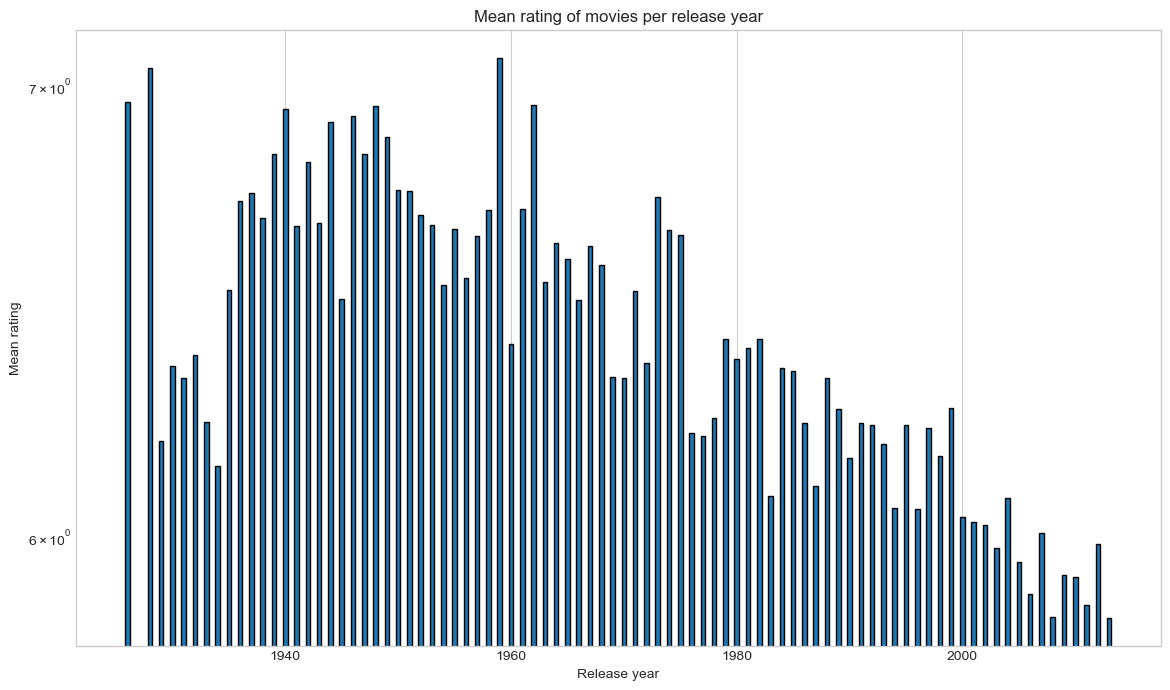

In [ ]:
# plot the mean rating per movie release year 

plt.figure(figsize=(14,8))
plt.bar(rating_per_year.index, rating_per_year['IMDb_rating'], 0.4, edgecolor = 'black')

plt.xlabel("Release year")
plt.yscale('log')
plt.ylabel("Mean rating")
plt.title("Mean rating of movies per release year")

> We clearly see a decreasing trend in the ratings of movies. This can be due to the fact that more and more films are produced, and statistcially, more and more films are less qualitative. Also, there is more room to creation and unicity with time, so every one will like special types of movies.

> Between 1929 and 1940, there are outliers. This can be explained to big innovation that saw the light from 1926-1927: notably the transition to sound-on-film technology, which marks the end of the silent-film era and the first animation movie. Those were the first of their types and the technologies might have taken a decade to improve to acceptable standards and it may also have taken some time for people to get used to it. 

Could be interesting to do an interpolation on this barplot and compare it to the interpolations for later plot by gender.

> As IMDb (and Internet) are pretty new tools on the studied time period, it is logical that there are much more votes on more recent films than old ones (about 100x more). We could thus ponderate the rating by the number of votes to have a real notion of appreciation from people.

In [ ]:
# obtain IMDb rating and votes per year for both genders
rating_per_year_gender = movie_gender.groupby(['Movie_release_year', 'Main_character_gender'])['IMDb_rating','IMDb_votes'].agg('mean')

# the function pd.xs (feature, level=1) allows to extract the second column indices (here, main character gender) from a groupby
rating_per_year_F = rating_per_year_gender.xs('F', level=1).rename(columns={"IMDb_rating": "IMDb_rating_F", "IMDb_votes": "IMDb_vote_F"})
rating_per_year_M = rating_per_year_gender.xs('M', level=1).rename(columns={"IMDb_rating": "IMDb_rating_M", "IMDb_votes": "IMDb_vote_M"})

rating_per_year_gender = pd.concat([rating_per_year_F, rating_per_year_M], axis=1)

rating_per_year_gender

/var/folders/f4/b7ft2_n14dsbh5_k5kt37m0m0000gn/T/ipykernel_1502/174806093.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  rating_per_year_gender = movie_gender.groupby(['Movie_release_year', 'Main_character_gender'])['IMDb_rating','IMDb_votes'].agg('mean')


IMDb_rating_F   IMDb_vote_F  IMDb_rating_M    IMDb_vote_M
Movie_release_year                                                           
1926                     7.133333   2164.666667       6.700000    1360.500000
1928                     7.133333   1151.666667       6.900000     660.000000
1929                     6.666667    848.000000       5.500000     412.500000
1930                     6.550000   3628.000000       6.233333    1780.666667
1931                     6.800000   2727.500000       5.400000     143.000000
...                           ...           ...            ...            ...
2009                     5.992086  51744.294964       5.880992   75647.450413
2010                     5.732500  43503.541667       6.014783   84238.104348
2011                     5.689394  55569.810606       5.962115   76310.722467
2012                     5.958462  54763.815385       5.999153  152392.237288
2013                     5.528571  53523.571429       5.980000  203843.666667

[87 rows x 4 columns]

Text(0.5, 1.0, 'Mean rating of movies per release year for masculine and feminine main character')

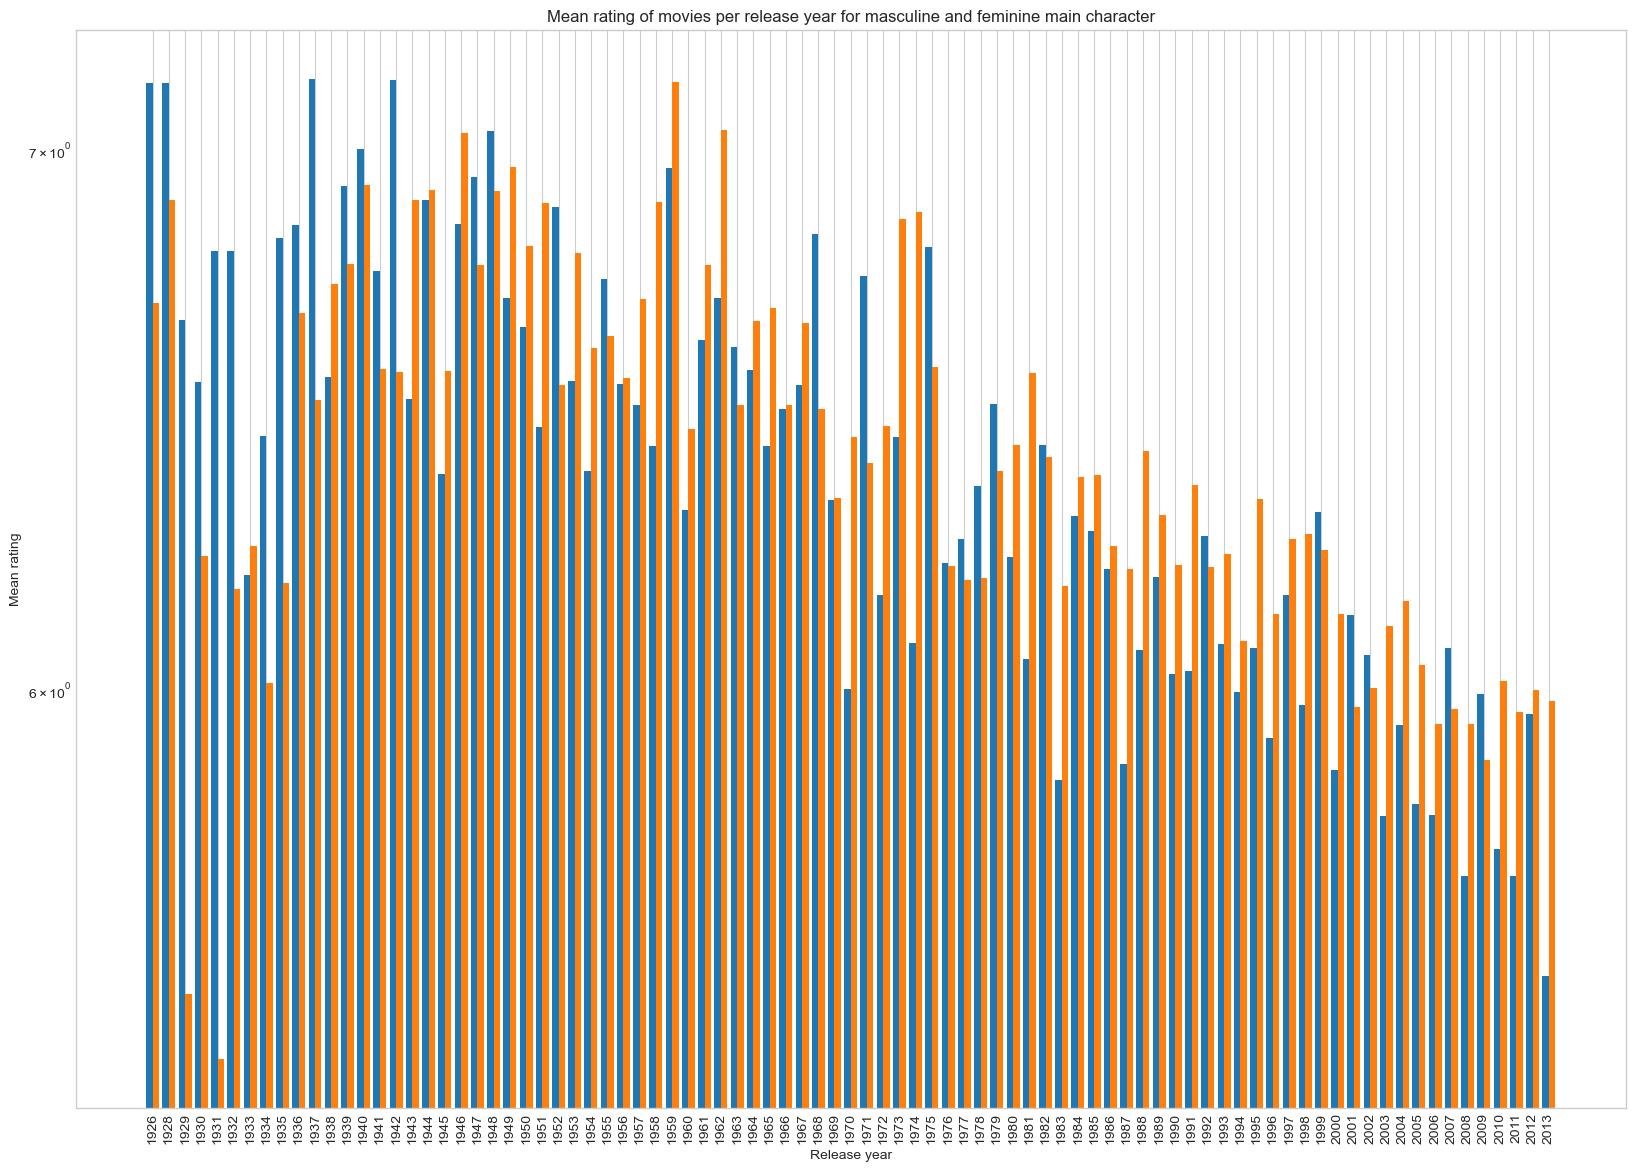

In [ ]:
# plot the mean IMDb_rating per movie release year for movie where main_character_gender is F and main_character_gender is M
X_axis = np.arange(len(rating_per_year_gender.index))

plt.figure(figsize=(20,14))
plt.bar(X_axis - 0.2, rating_per_year_gender['IMDb_rating_F'], 0.4, label = 'feminine main character') # doesn't plot lables!!
plt.bar(X_axis + 0.2, rating_per_year_gender['IMDb_rating_M'], 0.4, label = 'masculine main character')

 
plt.xticks(X_axis, rating_per_year_gender.index, rotation=90)
plt.xlabel("Release year")
plt.ylabel("Mean rating")
plt.yscale('log')
plt.title("Mean rating of movies per release year for masculine and feminine main character")


> Overall, we tend to see the same trends for both gender and also a similar trend as in the plot not by gender.
Between 1929-1939 approximately, we see that ratings for movies where the main character is a woman are way higher than when main character is a man. During this period, we saw on the general plot that ratings were very low overall. Looking at the votes in this period, there are more votes for feminine main character (twice as much) than for masculine main character. This period is thus not significant for the analysis of the evolution of the ratings for movies biased by the gender gap.

Could be interesting to do an interpolation on these barplots for both gender categories and compare it to general plot interpolation.

> From the mid-30s, there was a code and law enforcement at Hollywood to show good behaviour on screen. But in the years before that, woman were very free on screen and showed as powerful characters. There was thus a period were women were very present on screen. On average from given datasets, there were more women main characters than men before 1933. (https://lionessmagazine.com/strong-women-in-film-the-1930s-40s-and-50s/)

### iii. Is the work of women in general (other fields than acting) less/at the same level/more appreciated than the work of men? (using Oscar nominees for all jobs)

#### Compare all the Oscars nominees for all categories

#### Do an overall linear regression

## D. How do women interact, with other women and with men? <a name="Interaction"> </a>

### i. Use Bechdel tests dataset with movie dataset

#### Merge Bechdel tests dataset with movie dataset

#### Check evolution of Bechdel score through time

#### For what kind of movie is the Bechdel score the highest?

#  4. Conclusion <a id="Conclusion"> </a>

## Compare our approach and results with the Bechdel score

## General conclusion on evolution of gender gap in the film industry

## Impact of the METOO movement?